In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv


In [2]:
! pip install iterative-stratification


In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau



import numpy as np 
import pandas as pd 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, tnrange

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


plt.rcParams['figure.figsize'] = 35, 7

CGREEN  = '\33[32m'
CBLUE =  '\033[34m'
CRED = '\033[1;31m'
CEND  = '\33[0m'

def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [4]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
    
device

'cuda'

In [179]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')

train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')


In [180]:
def preprocess(df):
    df = df.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    return df

train = preprocess(train_features)
test = preprocess(test_features)

del train_targets['sig_id']

target = train_targets.loc[train['cp_type']==0].reset_index(drop=True)
train = train.loc[train['cp_type']==0].reset_index(drop=True)

In [181]:

top_features = [  1,   2,   3,   4,   5,   6,   7,   9,  11,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,
        32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
       198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
       267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
       281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294,
       295, 296, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
       310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
       324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
       337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
       350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 367, 368, 369, 370, 371, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 390, 391,
       392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
       405, 406, 407, 408, 409, 411, 412, 413, 414, 415, 416, 417, 418,
       419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
       432, 434, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446,
       447, 448, 449, 450, 453, 454, 456, 457, 458, 459, 460, 461, 462,
       463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
       476, 477, 478, 479, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 498, 500, 501, 502, 503, 505,
       506, 507, 509, 510, 511, 512, 513, 514, 515, 518, 519, 520, 521,
       522, 523, 524, 525, 526, 527, 528, 530, 531, 532, 534, 535, 536,
       538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 549, 550, 551,
       552, 554, 557, 559, 560, 561, 562, 565, 566, 567, 568, 569, 570,
       571, 572, 573, 574, 575, 577, 578, 580, 581, 582, 583, 584, 585,
       586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
       600, 601, 602, 606, 607, 608, 609, 611, 612, 613, 615, 616, 617,
       618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630,
       631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643, 644,
       645, 646, 647, 648, 649, 650, 651, 652, 654, 655, 656, 658, 659,
       660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
       673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685,
       686, 687, 688, 689, 691, 692, 693, 694, 695, 696, 697, 699, 700,
       701, 702, 704, 705, 707, 708, 709, 710, 711, 713, 714, 716, 717,
       718, 720, 721, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
       733, 734, 735, 737, 738, 739, 740, 742, 743, 744, 745, 746, 747,
       748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 759, 760, 761,
       762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774,
       775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788,
       789, 790, 792, 793, 794, 795, 796, 797, 798, 800, 801, 802, 803,
       804, 805, 806, 808, 809, 811, 813, 814, 815, 816, 817, 818, 819,
       821, 822, 823, 825, 826, 827, 828, 829, 830, 831, 832, 834, 835,
       837, 838, 839, 840, 841, 842, 845, 846, 847, 848, 850, 851, 852,
       854, 855, 856, 858, 859, 860, 861, 862, 864, 866, 867, 868, 869,
       870, 871, 872, 873, 874]

In [182]:

all_columns = train.columns
train= train[all_columns[top_features]]
test = test[all_columns[top_features]]

In [183]:
train = train.values
test = test.values
target = target.values

In [184]:
train.shape, test.shape, target.shape


((21948, 785), (3982, 785), (21948, 206))

In [185]:

class TrainDataset(Dataset):
    def __init__(self, train,targets, noise ):
        
        self.features  = train
        self.targets = targets
        self.noise = noise
        
    def sizes(self):
        print("features size = ", self.features.shape[1])
        print("targets size = ", self.targets.shape[1])

        
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx]).float()
        
#         if self.noise == True:
# #             print("noisy boi")
#             feature  = feature + torch.randn_like(feature)/150
            
        target = torch.tensor(self.targets[idx]).float()
        
        return feature, target

In [186]:

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def train_step(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    pred = model(x.to(device))
    y = y.float()
    loss = criterion(pred,y.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

In [187]:

def validate_fn(model, val_loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch 
            pred = model(x.to(device))
            loss = criterion(pred.cpu(),y).item()
            losses.append(loss)
    return np.array(losses).mean()

def create_weights_from_val_losses(val_losses_np):
    w = 1/val_losses_np
    w_norm = w/w.max()
    return w_norm


def train_one_fold(model,num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 1, show_plots = False, train = True, validate = True):
    
    losses = []
    val_losses = []
    learning_rates = []    
    best_loss = 1000000

    for epoch in range(num_epochs):

            
        if train == True:
            model.train()
            losses_temp = []
            for batch in train_loader:
                (x_batch, y_batch) = batch
                loss = train_step(x_batch.to(device), y_batch.to(device), model, optimizer, criterion)
                losses_temp.append(loss)
            losses.append(torch.mean(torch.tensor(losses_temp)))
            
            if scheduler is not None:
                scheduler.step(1.)   ## lr decay caller 

            learning_rates.append(get_lr(optimizer))
            

        if validate == True:
            val_losses.append(validate_fn(model, val_loader, criterion, device))
            

        
        if train == True:
            print ("epoch ", epoch+1, " out of ", num_epochs, end = "      >" )

            if val_losses[-1] <= best_loss:

                print(CGREEN, "Val loss decreased from:", best_loss, " to ", val_losses[-1], CEND, end = "   >")
                best_loss = val_losses[-1]
                name = "./model_" + str(fold_number)+".pth"
                print("saving model as: ", name)
                torch.save(model.state_dict(), name)

            else: 
                print("showing no improvements, best loss yet:", best_loss)

        if show_plots == True:

            show_lr(learning_rates)
            plt.plot(val_losses, label = "val")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(val_losses[4:], label = "val after main drop", c = "g")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(losses, label = "train")
            plt.legend()
            plt.grid()
            plt.show()
        
    if train == True:
        return min(val_losses), name
    else:
        return min(val_losses)

In [188]:
train_main = train[:-1000]
target_main = target[:-1000]

train_hold = train[-1000:]
target_hold = target[-1000:]

hold_dataset = TrainDataset(train_hold, target_hold, noise = False)
hold_loader = DataLoader(dataset=hold_dataset, batch_size=512, shuffle= False)



num_folds = 10

mskf = MultilabelStratifiedKFold(n_splits=num_folds, shuffle=True, random_state=0)

train_loaders = []
val_loaders = []

for k , (train_idx,valid_idx) in enumerate(mskf.split(train_main,target_main)):

    x_train,x_valid,y_train,y_valid = train_main[train_idx,:],train_main[valid_idx,:],target_main[train_idx,:],target_main[valid_idx,:]

    input_size = x_train.shape[1]
    output_size = target.shape[1]


    train_dataset = TrainDataset(x_train, y_train, noise = False)
    valid_dataset = TrainDataset(x_valid, y_valid, noise = False)

    train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

    val_loader = DataLoader(dataset=valid_dataset, batch_size=256, shuffle = False)
    
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


148 batches 
9  batches 


In [189]:

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(785)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(785, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 1048))
        
        self.batch_norm3 = nn.BatchNorm1d(1048)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(1048, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

In [190]:
model_filenames = []
val_losses = []
model_classes = []

num_epochs = 55 ## changes here 

k = 0
for train_loader, val_loader in zip(train_loaders,val_loaders):
    model = Model()
    model_classes.append(Model())
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = 0.004299882049752947, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', 
                                                     factor=0.1, ## wooo hoo
                                                     patience=7, ## was 3 for 158 
                                                     eps=1e-4, 
                                                     verbose=True)


    criterion = nn.BCEWithLogitsLoss()

    val_loss, filename = train_one_fold(model, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = k+1)
    
    print("hold loss: ", str(validate_fn(model, hold_loader, criterion, device)))
    val_losses.append(val_loss)
    model_filenames.append(filename)
    k+=1
    
print(CBLUE, "Training complete", CEND)

epoch  1  out of  55      > Val loss decreased from: 1000000  to  0.020445768410960834    >saving model as:  ./model_1.pth
epoch  2  out of  55      > Val loss decreased from: 0.020445768410960834  to  0.01938810385763645    >saving model as:  ./model_1.pth
epoch  3  out of  55      > Val loss decreased from: 0.01938810385763645  to  0.018534812869297132    >saving model as:  ./model_1.pth
epoch  4  out of  55      > Val loss decreased from: 0.018534812869297132  to  0.01790077777372466    >saving model as:  ./model_1.pth
epoch  5  out of  55      > Val loss decreased from: 0.01790077777372466  to  0.017422927129599784    >saving model as:  ./model_1.pth
epoch  6  out of  55      > Val loss decreased from: 0.017422927129599784  to  0.01707667236526807    >saving model as:  ./model_1.pth
epoch  7  out of  55      >showing no improvements, best loss yet: 0.01707667236526807
epoch  8  out of  55      >showing no improvements, best loss yet: 0.01707667236526807
Epoch     9: reducing learni

epoch  16  out of  55      > Val loss decreased from: 0.015807581341101065  to  0.015739068078498047    >saving model as:  ./model_2.pth
Epoch    17: reducing learning rate of group 0 to 4.2999e-05.
epoch  17  out of  55      >showing no improvements, best loss yet: 0.015739068078498047
epoch  18  out of  55      > Val loss decreased from: 0.015739068078498047  to  0.01568432514452272    >saving model as:  ./model_2.pth
epoch  19  out of  55      > Val loss decreased from: 0.01568432514452272  to  0.015614625480439927    >saving model as:  ./model_2.pth
epoch  20  out of  55      >showing no improvements, best loss yet: 0.015614625480439927
epoch  21  out of  55      >showing no improvements, best loss yet: 0.015614625480439927
epoch  22  out of  55      >showing no improvements, best loss yet: 0.015614625480439927
epoch  23  out of  55      > Val loss decreased from: 0.015614625480439927  to  0.015611146369742023    >saving model as:  ./model_2.pth
epoch  24  out of  55      > Val los

epoch  31  out of  55      > Val loss decreased from: 0.015916183073487546  to  0.015907614284919366    >saving model as:  ./model_3.pth
epoch  32  out of  55      >showing no improvements, best loss yet: 0.015907614284919366
epoch  33  out of  55      >showing no improvements, best loss yet: 0.015907614284919366
epoch  34  out of  55      > Val loss decreased from: 0.015907614284919366  to  0.01589901362442308    >saving model as:  ./model_3.pth
epoch  35  out of  55      > Val loss decreased from: 0.01589901362442308  to  0.01587610070904096    >saving model as:  ./model_3.pth
epoch  36  out of  55      > Val loss decreased from: 0.01587610070904096  to  0.01586792328291469    >saving model as:  ./model_3.pth
epoch  37  out of  55      >showing no improvements, best loss yet: 0.01586792328291469
epoch  38  out of  55      >showing no improvements, best loss yet: 0.01586792328291469
epoch  39  out of  55      >showing no improvements, best loss yet: 0.01586792328291469
epoch  40  out 

epoch  49  out of  55      > Val loss decreased from: 0.016390667089985475  to  0.016383753158152103    >saving model as:  ./model_4.pth
epoch  50  out of  55      >showing no improvements, best loss yet: 0.016383753158152103
epoch  51  out of  55      >showing no improvements, best loss yet: 0.016383753158152103
epoch  52  out of  55      >showing no improvements, best loss yet: 0.016383753158152103
epoch  53  out of  55      >showing no improvements, best loss yet: 0.016383753158152103
epoch  54  out of  55      >showing no improvements, best loss yet: 0.016383753158152103
epoch  55  out of  55      >showing no improvements, best loss yet: 0.016383753158152103
hold loss:  0.015587451867759228
epoch  1  out of  55      > Val loss decreased from: 1000000  to  0.02182572790318065    >saving model as:  ./model_5.pth
epoch  2  out of  55      > Val loss decreased from: 0.02182572790318065  to  0.019543886391652956    >saving model as:  ./model_5.pth
epoch  3  out of  55      > Val loss de

epoch  11  out of  55      > Val loss decreased from: 0.016588143590423796  to  0.01643646912028392    >saving model as:  ./model_6.pth
epoch  12  out of  55      > Val loss decreased from: 0.01643646912028392  to  0.01636581640276644    >saving model as:  ./model_6.pth
epoch  13  out of  55      > Val loss decreased from: 0.01636581640276644  to  0.01621791482385662    >saving model as:  ./model_6.pth
epoch  14  out of  55      > Val loss decreased from: 0.01621791482385662  to  0.016175126656889915    >saving model as:  ./model_6.pth
epoch  15  out of  55      >showing no improvements, best loss yet: 0.016175126656889915
epoch  16  out of  55      > Val loss decreased from: 0.016175126656889915  to  0.016120483581390645    >saving model as:  ./model_6.pth
Epoch    17: reducing learning rate of group 0 to 4.2999e-05.
epoch  17  out of  55      > Val loss decreased from: 0.016120483581390645  to  0.01610208944314056    >saving model as:  ./model_6.pth
epoch  18  out of  55      > Val l

epoch  25  out of  55      > Val loss decreased from: 0.016004790758921042  to  0.01600113283428881    >saving model as:  ./model_7.pth
epoch  26  out of  55      > Val loss decreased from: 0.01600113283428881  to  0.015989832476609282    >saving model as:  ./model_7.pth
epoch  27  out of  55      >showing no improvements, best loss yet: 0.015989832476609282
epoch  28  out of  55      >showing no improvements, best loss yet: 0.015989832476609282
epoch  29  out of  55      >showing no improvements, best loss yet: 0.015989832476609282
epoch  30  out of  55      > Val loss decreased from: 0.015989832476609282  to  0.015979772433638573    >saving model as:  ./model_7.pth
epoch  31  out of  55      >showing no improvements, best loss yet: 0.015979772433638573
epoch  32  out of  55      >showing no improvements, best loss yet: 0.015979772433638573
epoch  33  out of  55      > Val loss decreased from: 0.015979772433638573  to  0.015955412139495213    >saving model as:  ./model_7.pth
epoch  34

epoch  46  out of  55      >showing no improvements, best loss yet: 0.015684094176524215
epoch  47  out of  55      >showing no improvements, best loss yet: 0.015684094176524215
epoch  48  out of  55      >showing no improvements, best loss yet: 0.015684094176524215
epoch  49  out of  55      >showing no improvements, best loss yet: 0.015684094176524215
epoch  50  out of  55      >showing no improvements, best loss yet: 0.015684094176524215
epoch  51  out of  55      >showing no improvements, best loss yet: 0.015684094176524215
epoch  52  out of  55      >showing no improvements, best loss yet: 0.015684094176524215
epoch  53  out of  55      >showing no improvements, best loss yet: 0.015684094176524215
epoch  54  out of  55      >showing no improvements, best loss yet: 0.015684094176524215
epoch  55  out of  55      >showing no improvements, best loss yet: 0.015684094176524215
hold loss:  0.015694231260567904
epoch  1  out of  55      > Val loss decreased from: 1000000  to  0.021321042

Epoch     9: reducing learning rate of group 0 to 4.2999e-04.
epoch  9  out of  55      >showing no improvements, best loss yet: 0.016872844762272306
epoch  10  out of  55      > Val loss decreased from: 0.016872844762272306  to  0.016307240248554282    >saving model as:  ./model_10.pth
epoch  11  out of  55      > Val loss decreased from: 0.016307240248554282  to  0.016139698318309255    >saving model as:  ./model_10.pth
epoch  12  out of  55      > Val loss decreased from: 0.016139698318309255  to  0.016086041720377073    >saving model as:  ./model_10.pth
epoch  13  out of  55      > Val loss decreased from: 0.016086041720377073  to  0.016004773891634412    >saving model as:  ./model_10.pth
epoch  14  out of  55      > Val loss decreased from: 0.016004773891634412  to  0.015992985107004642    >saving model as:  ./model_10.pth
epoch  15  out of  55      > Val loss decreased from: 0.015992985107004642  to  0.015936951463421185    >saving model as:  ./model_10.pth
epoch  16  out of  55 

In [191]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(785)
        self.dropout1 = nn.Dropout(0.5)
        self.dense1 = nn.utils.weight_norm(nn.Linear(785, 790))
        
#         self.batch_norm2 = nn.BatchNorm1d(900)
#         self.dropout2 = nn.Dropout(0.5)
#         self.dense2 = nn.utils.weight_norm(nn.Linear(900, 900))
        
        self.batch_norm3 = nn.BatchNorm1d(790)
        self.dense3 = nn.utils.weight_norm(nn.Linear(790, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
#         x = self.batch_norm2(x)
#         x = self.dropout2(x)
#         x = F.leaky_relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dense3(x)
        
        return x

In [193]:
num_epochs = 65 ## changes here 

k = 0
for train_loader, val_loader in zip(train_loaders,val_loaders):
    model = Model_2()
    model_classes.append(Model_2())
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = 4e-3, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', 
                                                     factor=0.1, ## wooo hoo
                                                     patience=7, ## was 3 for 158 
                                                     eps=1e-4, 
                                                     verbose=True)


    criterion = nn.BCEWithLogitsLoss()

    val_loss, filename = train_one_fold(model, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 100 + k + 1)
    print("hold loss: ", str(validate_fn(model, hold_loader, criterion, device)))


    val_losses.append(val_loss)
    model_filenames.append(filename)
    
    k+=1
    
print(CBLUE, "Training complete", CEND)

epoch  1  out of  65      > Val loss decreased from: 1000000  to  0.020442937397294574    >saving model as:  ./model_101.pth
epoch  2  out of  65      > Val loss decreased from: 0.020442937397294574  to  0.01898438586956925    >saving model as:  ./model_101.pth
epoch  3  out of  65      > Val loss decreased from: 0.01898438586956925  to  0.01806139387190342    >saving model as:  ./model_101.pth
epoch  4  out of  65      > Val loss decreased from: 0.01806139387190342  to  0.017592148441407416    >saving model as:  ./model_101.pth
epoch  5  out of  65      > Val loss decreased from: 0.017592148441407416  to  0.017331776933537588    >saving model as:  ./model_101.pth
epoch  6  out of  65      > Val loss decreased from: 0.017331776933537588  to  0.01730946306553152    >saving model as:  ./model_101.pth
epoch  7  out of  65      > Val loss decreased from: 0.01730946306553152  to  0.017130275774333212    >saving model as:  ./model_101.pth
epoch  8  out of  65      >showing no improvements, b

epoch  7  out of  65      >showing no improvements, best loss yet: 0.017056639306247234
epoch  8  out of  65      > Val loss decreased from: 0.017056639306247234  to  0.016961390463014443    >saving model as:  ./model_102.pth
Epoch     9: reducing learning rate of group 0 to 4.0000e-04.
epoch  9  out of  65      > Val loss decreased from: 0.016961390463014443  to  0.01684983116057184    >saving model as:  ./model_102.pth
epoch  10  out of  65      > Val loss decreased from: 0.01684983116057184  to  0.016362874975634947    >saving model as:  ./model_102.pth
epoch  11  out of  65      > Val loss decreased from: 0.016362874975634947  to  0.01624060215221511    >saving model as:  ./model_102.pth
epoch  12  out of  65      > Val loss decreased from: 0.01624060215221511  to  0.016192875802516937    >saving model as:  ./model_102.pth
epoch  13  out of  65      > Val loss decreased from: 0.016192875802516937  to  0.016134236421849992    >saving model as:  ./model_102.pth
epoch  14  out of  65 

epoch  11  out of  65      > Val loss decreased from: 0.0167413709892167  to  0.01669391534394688    >saving model as:  ./model_103.pth
epoch  12  out of  65      > Val loss decreased from: 0.01669391534394688  to  0.0166158564388752    >saving model as:  ./model_103.pth
epoch  13  out of  65      > Val loss decreased from: 0.0166158564388752  to  0.01654809092481931    >saving model as:  ./model_103.pth
epoch  14  out of  65      > Val loss decreased from: 0.01654809092481931  to  0.01649893903070026    >saving model as:  ./model_103.pth
epoch  15  out of  65      >showing no improvements, best loss yet: 0.01649893903070026
epoch  16  out of  65      >showing no improvements, best loss yet: 0.01649893903070026
Epoch    17: reducing learning rate of group 0 to 4.0000e-05.
epoch  17  out of  65      >showing no improvements, best loss yet: 0.01649893903070026
epoch  18  out of  65      > Val loss decreased from: 0.01649893903070026  to  0.01644374906188912    >saving model as:  ./model_

epoch  15  out of  65      > Val loss decreased from: 0.017064189538359642  to  0.017061238694522116    >saving model as:  ./model_104.pth
epoch  16  out of  65      > Val loss decreased from: 0.017061238694522116  to  0.01697739793194665    >saving model as:  ./model_104.pth
Epoch    17: reducing learning rate of group 0 to 4.0000e-05.
epoch  17  out of  65      >showing no improvements, best loss yet: 0.01697739793194665
epoch  18  out of  65      > Val loss decreased from: 0.01697739793194665  to  0.016941778361797333    >saving model as:  ./model_104.pth
epoch  19  out of  65      > Val loss decreased from: 0.016941778361797333  to  0.01692476061483224    >saving model as:  ./model_104.pth
epoch  20  out of  65      > Val loss decreased from: 0.01692476061483224  to  0.01689489009893603    >saving model as:  ./model_104.pth
epoch  21  out of  65      >showing no improvements, best loss yet: 0.01689489009893603
epoch  22  out of  65      > Val loss decreased from: 0.0168948900989360

epoch  21  out of  65      > Val loss decreased from: 0.01657228057997094  to  0.01656821256296502    >saving model as:  ./model_105.pth
epoch  22  out of  65      > Val loss decreased from: 0.01656821256296502  to  0.016547128247718017    >saving model as:  ./model_105.pth
epoch  23  out of  65      >showing no improvements, best loss yet: 0.016547128247718017
epoch  24  out of  65      > Val loss decreased from: 0.016547128247718017  to  0.016544345145424206    >saving model as:  ./model_105.pth
epoch  25  out of  65      >showing no improvements, best loss yet: 0.016544345145424206
epoch  26  out of  65      >showing no improvements, best loss yet: 0.016544345145424206
epoch  27  out of  65      > Val loss decreased from: 0.016544345145424206  to  0.0165383190744453    >saving model as:  ./model_105.pth
epoch  28  out of  65      > Val loss decreased from: 0.0165383190744453  to  0.01652740863048368    >saving model as:  ./model_105.pth
epoch  29  out of  65      >showing no improve

epoch  25  out of  65      > Val loss decreased from: 0.016239921355413064  to  0.016216996022396617    >saving model as:  ./model_106.pth
epoch  26  out of  65      >showing no improvements, best loss yet: 0.016216996022396617
epoch  27  out of  65      >showing no improvements, best loss yet: 0.016216996022396617
epoch  28  out of  65      > Val loss decreased from: 0.016216996022396617  to  0.01619756728824642    >saving model as:  ./model_106.pth
epoch  29  out of  65      > Val loss decreased from: 0.01619756728824642  to  0.016174195230835013    >saving model as:  ./model_106.pth
epoch  30  out of  65      >showing no improvements, best loss yet: 0.016174195230835013
epoch  31  out of  65      >showing no improvements, best loss yet: 0.016174195230835013
epoch  32  out of  65      > Val loss decreased from: 0.016174195230835013  to  0.016156431494487658    >saving model as:  ./model_106.pth
epoch  33  out of  65      >showing no improvements, best loss yet: 0.016156431494487658
e

epoch  33  out of  65      > Val loss decreased from: 0.01636301146613227  to  0.01634050512479411    >saving model as:  ./model_107.pth
epoch  34  out of  65      >showing no improvements, best loss yet: 0.01634050512479411
epoch  35  out of  65      >showing no improvements, best loss yet: 0.01634050512479411
epoch  36  out of  65      >showing no improvements, best loss yet: 0.01634050512479411
epoch  37  out of  65      > Val loss decreased from: 0.01634050512479411  to  0.016300621028575633    >saving model as:  ./model_107.pth
epoch  38  out of  65      >showing no improvements, best loss yet: 0.016300621028575633
epoch  39  out of  65      >showing no improvements, best loss yet: 0.016300621028575633
epoch  40  out of  65      >showing no improvements, best loss yet: 0.016300621028575633
epoch  41  out of  65      >showing no improvements, best loss yet: 0.016300621028575633
epoch  42  out of  65      >showing no improvements, best loss yet: 0.016300621028575633
epoch  43  out o

epoch  43  out of  65      > Val loss decreased from: 0.01608555619087484  to  0.01606309237993426    >saving model as:  ./model_108.pth
epoch  44  out of  65      >showing no improvements, best loss yet: 0.01606309237993426
epoch  45  out of  65      >showing no improvements, best loss yet: 0.01606309237993426
epoch  46  out of  65      > Val loss decreased from: 0.01606309237993426  to  0.01604532729834318    >saving model as:  ./model_108.pth
epoch  47  out of  65      >showing no improvements, best loss yet: 0.01604532729834318
epoch  48  out of  65      >showing no improvements, best loss yet: 0.01604532729834318
epoch  49  out of  65      > Val loss decreased from: 0.01604532729834318  to  0.016030050503710907    >saving model as:  ./model_108.pth
epoch  50  out of  65      >showing no improvements, best loss yet: 0.016030050503710907
epoch  51  out of  65      > Val loss decreased from: 0.016030050503710907  to  0.01601959050943454    >saving model as:  ./model_108.pth
epoch  52

epoch  54  out of  65      >showing no improvements, best loss yet: 0.016251168110304408
epoch  55  out of  65      >showing no improvements, best loss yet: 0.016251168110304408
epoch  56  out of  65      >showing no improvements, best loss yet: 0.016251168110304408
epoch  57  out of  65      > Val loss decreased from: 0.016251168110304408  to  0.016237136493954394    >saving model as:  ./model_109.pth
epoch  58  out of  65      >showing no improvements, best loss yet: 0.016237136493954394
epoch  59  out of  65      > Val loss decreased from: 0.016237136493954394  to  0.016236565075814724    >saving model as:  ./model_109.pth
epoch  60  out of  65      >showing no improvements, best loss yet: 0.016236565075814724
epoch  61  out of  65      >showing no improvements, best loss yet: 0.016236565075814724
epoch  62  out of  65      >showing no improvements, best loss yet: 0.016236565075814724
epoch  63  out of  65      >showing no improvements, best loss yet: 0.016236565075814724
epoch  64 

epoch  62  out of  65      >showing no improvements, best loss yet: 0.01590598871310552
epoch  63  out of  65      > Val loss decreased from: 0.01590598871310552  to  0.015885442081424925    >saving model as:  ./model_110.pth
epoch  64  out of  65      >showing no improvements, best loss yet: 0.015885442081424925
epoch  65  out of  65      >showing no improvements, best loss yet: 0.015885442081424925
hold loss:  0.015865112654864788
 Training complete 


In [194]:
class pytorch_model():
    def __init__(self, model_class, model_path, device):
        
        self.model_class = model_class
        self.model_path = model_path
        self.device = device
        
        self.model = self.model_class()
        self.model.load_state_dict(torch.load(self.model_path))
        self.model.to(self.device)
        self.model.eval()
        
    def predict(self, x):
        
        pred = self.model(x)
        
        return pred 
    
    def __call__(self, x):
        return self.predict(x)

In [195]:
all_models = []

for i in range(len(model_filenames)):
    
    if i < 10:
        model_class = Model
    else:
        model_class = Model_2
    
    m = pytorch_model(model_class, model_filenames[i], device = device)
    
    all_models.append(m)
    

In [196]:
class blend(nn.Module):
    def __init__(self,weights, model_list ,device = device):
        super(blend, self).__init__()
        self.model_list = model_list
        self.weights = weights 
       
   

    def forward(self, x):
        
        x_list = [self.model_list[i](x).detach().cpu() for i in range(len(self.model_list))]
        
        final_pred = torch.zeros_like(x_list[0])
        
        for i in range(len(x_list)):
            final_pred += x_list[i] * self.weights[i]
            
        final_pred = final_pred/self.weights.sum()
        
        return final_pred.cpu()
    
    def __cal__(self,x):
        return self.forward(x)

In [197]:
def inference_fn(model, test_features, device):
    results = np.zeros([test_features.shape[0], 206])
    
    test_features_tensor = torch.tensor(test_features).float().to(device)
    
    rows = model(test_features_tensor).sigmoid().detach().cpu().numpy()
    
    results = rows 

    return results 


def log_loss_metric(y_true, y_pred):
    y_pred_clip = np.clip(y_pred, 1e-15, 1 - 1e-15)
    loss = - np.mean(np.mean(y_true * np.log(y_pred_clip) + (1 - y_true) * np.log(1 - y_pred_clip), axis = 1))
    return loss


def create_weights_from_val_losses(val_losses_np):
    w = 1/val_losses_np
    w_norm = w/w.max()
    return w_norm

In [198]:
sample_infer = inference_fn(all_models[0], train_hold, device)
loss = log_loss_metric(target_hold, sample_infer)
loss

0.015662979435149976

In [199]:
poop_weights = np.ones(20)

blend_boi = blend(poop_weights, all_models)

sample_infer = inference_fn(blend_boi, train_hold, device)
loss = log_loss_metric(target_hold, sample_infer)
loss

0.015538968382860318

In [200]:
single_log_losses = {}

k = 1
for model in all_models:
    name = "model_" + str(k)
    sample_infer = inference_fn(model, train_hold, device)
    loss = log_loss_metric(target_hold, sample_infer)
    single_log_losses[name] = loss
    k+=1 
    

In [201]:
single_log_losses

{'model_1': 0.015662979435149976,
 'model_2': 0.01562938370767693,
 'model_3': 0.015653746767999296,
 'model_4': 0.015573926065456852,
 'model_5': 0.01568373459073663,
 'model_6': 0.01562661157076318,
 'model_7': 0.015649537532433196,
 'model_8': 0.015625682825464997,
 'model_9': 0.015544245282317876,
 'model_10': 0.015603236145748859,
 'model_11': 0.015820372850272622,
 'model_12': 0.015793723128940715,
 'model_13': 0.015926749418353484,
 'model_14': 0.015911467114553057,
 'model_15': 0.015914084571175293,
 'model_16': 0.01580641474177586,
 'model_17': 0.01590473575816967,
 'model_18': 0.015869411766955506,
 'model_19': 0.01591597612690223,
 'model_20': 0.015875578261677695}

In [205]:
good_weights = create_weights_from_val_losses(np.array(list(single_log_losses.values())))

In [206]:
blend_boi = blend(good_weights, all_models)

sample_infer = inference_fn(blend_boi, train_hold, device)
loss = log_loss_metric(target_hold, sample_infer)
single_log_losses["loss_based_blend"] = loss
loss

0.015537722460562764

In [207]:
len(good_weights)

20

In [208]:
import optuna

In [209]:
def find_loss(params):
    
    weights_np = np.array(list(params.values()))
    blend_boi = blend(weights_np, all_models)

    sample_infer = inference_fn(blend_boi, train_hold, device)
    loss = log_loss_metric(target_hold, sample_infer)
    
    return loss

In [210]:

def objective(trial):
    params = {
        "w1": trial.suggest_uniform("w1", 0.01, 1.0),
        "w2": trial.suggest_uniform("w2", 0.01, 1.0),
        "w3": trial.suggest_uniform("w3", 0.01, 1.0),
        "w4": trial.suggest_uniform("w4", 0.01, 1.0),
        "w5": trial.suggest_uniform("w5", 0.01, 1.0),
        "w6": trial.suggest_uniform("w6", 0.01, 1.0),
        "w7": trial.suggest_uniform("w7", 0.01, 1.0),
        "w8": trial.suggest_uniform("w8", 0.01, 1.0),
        "w9": trial.suggest_uniform("w9", 0.01, 1.0),
        "w10": trial.suggest_uniform("w10", 0.01, 1.0),
        "w11": trial.suggest_uniform("w11", 0.01, 1.0),
        "w12": trial.suggest_uniform("w12", 0.01, 1.0),
        "w13": trial.suggest_uniform("w13", 0.01, 1.0),
        "w14": trial.suggest_uniform("w14", 0.01, 1.0),
        "w15": trial.suggest_uniform("w15", 0.01, 1.0),
        "w16": trial.suggest_uniform("w16", 0.01, 1.0),
        "w17": trial.suggest_uniform("w17", 0.01, 1.0),
        "w18": trial.suggest_uniform("w18", 0.01, 1.0),
        "w19": trial.suggest_uniform("w19", 0.01, 1.0),
        "w20": trial.suggest_uniform("w20", 0.01, 1.0)
#         "w21": trial.suggest_uniform("w21", 0.01, 1.0),
#         "w22": trial.suggest_uniform("w22", 0.01, 1.0),
#         "w23": trial.suggest_uniform("w23", 0.01, 1.0),
#         "w24": trial.suggest_uniform("w24", 0.01, 1.0),
#         "w25": trial.suggest_uniform("w25", 0.01, 1.0)



    }
    loss_ = find_loss(params) 
    return loss_


In [211]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000)

[I 2020-10-03 10:38:40,442] A new study created in memory with name: no-name-648b8ab0-1210-4162-b385-6d9620b4ee6d
[I 2020-10-03 10:38:40,500] Trial 0 finished with value: 0.015581329164835648 and parameters: {'w1': 0.8814906257187607, 'w2': 0.4440779806880206, 'w3': 0.9207170996089712, 'w4': 0.4863849020626112, 'w5': 0.8953379719257685, 'w6': 0.11785746468761836, 'w7': 0.2876625926905444, 'w8': 0.10482652782827268, 'w9': 0.08415515935585868, 'w10': 0.26702127904596057, 'w11': 0.5157190528018323, 'w12': 0.7775697344557176, 'w13': 0.993766933405403, 'w14': 0.8985245652996434, 'w15': 0.05458536035301441, 'w16': 0.8023465010934244, 'w17': 0.7088149839853735, 'w18': 0.2749663712200235, 'w19': 0.8626611293676099, 'w20': 0.6913067449694484}. Best is trial 0 with value: 0.015581329164835648.
[I 2020-10-03 10:38:40,549] Trial 1 finished with value: 0.015526939179658758 and parameters: {'w1': 0.17263380500271064, 'w2': 0.757024153466367, 'w3': 0.19433514081115624, 'w4': 0.7265262809698898, 'w5':

[I 2020-10-03 10:38:41,082] Trial 11 finished with value: 0.015523343858028619 and parameters: {'w1': 0.6819101452957705, 'w2': 0.12846851174605367, 'w3': 0.6049414610020414, 'w4': 0.042170128949011454, 'w5': 0.2232307857189866, 'w6': 0.3940077769580319, 'w7': 0.03304932108169017, 'w8': 0.022721340536797252, 'w9': 0.9782808577754837, 'w10': 0.4685389723013533, 'w11': 0.16745229664611827, 'w12': 0.9730327359763089, 'w13': 0.4447225142536529, 'w14': 0.040890056520980655, 'w15': 0.029691168974812318, 'w16': 0.5524040408819451, 'w17': 0.32715647232908923, 'w18': 0.012557400594841853, 'w19': 0.583752930833405, 'w20': 0.05634963353087176}. Best is trial 8 with value: 0.015494905251541421.
[I 2020-10-03 10:38:41,160] Trial 12 finished with value: 0.015517547680656706 and parameters: {'w1': 0.6700470241222128, 'w2': 0.46561315738169223, 'w3': 0.6816696343408479, 'w4': 0.14921874061233992, 'w5': 0.26516900403663846, 'w6': 0.44633278496137524, 'w7': 0.01625703287117628, 'w8': 0.961139504821271, 

[I 2020-10-03 10:38:41,921] Trial 22 finished with value: 0.01550679170193926 and parameters: {'w1': 0.7529406072736341, 'w2': 0.5945311565728831, 'w3': 0.11478224204374873, 'w4': 0.8410652967138902, 'w5': 0.4749626734189097, 'w6': 0.26368661466511606, 'w7': 0.36128701390635426, 'w8': 0.5847466192190914, 'w9': 0.49519941744271256, 'w10': 0.8833094004154542, 'w11': 0.0971668361629355, 'w12': 0.6545073442885101, 'w13': 0.017697116325825255, 'w14': 0.3627289677809878, 'w15': 0.10946217744987317, 'w16': 0.1268637228996574, 'w17': 0.19467822779000632, 'w18': 0.7253413538339158, 'w19': 0.649081800003875, 'w20': 0.28304058281165534}. Best is trial 8 with value: 0.015494905251541421.
[I 2020-10-03 10:38:42,000] Trial 23 finished with value: 0.015507467513250515 and parameters: {'w1': 0.7806504419677698, 'w2': 0.5741580544655953, 'w3': 0.4656328441062004, 'w4': 0.8250937835895911, 'w5': 0.6592763876408985, 'w6': 0.265672619030532, 'w7': 0.38761424762146884, 'w8': 0.49291620886578363, 'w9': 0.35

[I 2020-10-03 10:38:42,783] Trial 33 finished with value: 0.015500728136023472 and parameters: {'w1': 0.16416332151678675, 'w2': 0.8824452133932927, 'w3': 0.9355268090814362, 'w4': 0.761510399105951, 'w5': 0.15034245929275036, 'w6': 0.8829044957589488, 'w7': 0.4745881657110671, 'w8': 0.013220750290612926, 'w9': 0.9574407579204707, 'w10': 0.2614891274281963, 'w11': 0.24447836366286463, 'w12': 0.1368570847517308, 'w13': 0.7910091375839208, 'w14': 0.18385786075714153, 'w15': 0.01893423334621032, 'w16': 0.7537071583008855, 'w17': 0.06432964398687217, 'w18': 0.8837606412006105, 'w19': 0.43169702726559145, 'w20': 0.319098125038659}. Best is trial 8 with value: 0.015494905251541421.
[I 2020-10-03 10:38:42,864] Trial 34 finished with value: 0.015512146232976242 and parameters: {'w1': 0.20795924641576105, 'w2': 0.9414417937838236, 'w3': 0.9206589749758327, 'w4': 0.3378017112468752, 'w5': 0.1514565127236555, 'w6': 0.8989644714415858, 'w7': 0.7046890135101516, 'w8': 0.0789032469451257, 'w9': 0.98

[I 2020-10-03 10:38:43,676] Trial 44 finished with value: 0.015510953696230526 and parameters: {'w1': 0.12660972958600186, 'w2': 0.9158488297027131, 'w3': 0.8775490818928589, 'w4': 0.46580695475458483, 'w5': 0.14311630408161496, 'w6': 0.9531746201332102, 'w7': 0.9938779929770822, 'w8': 0.5572526223199172, 'w9': 0.8927014005793464, 'w10': 0.12084669761983866, 'w11': 0.9977465235688336, 'w12': 0.036076637785238244, 'w13': 0.8737428939307296, 'w14': 0.646002312519558, 'w15': 0.15203045889936626, 'w16': 0.8094586948581171, 'w17': 0.0679275368000964, 'w18': 0.057064074349222296, 'w19': 0.3527612173182534, 'w20': 0.4385166618875639}. Best is trial 8 with value: 0.015494905251541421.
[I 2020-10-03 10:38:43,760] Trial 45 finished with value: 0.0155087443812442 and parameters: {'w1': 0.05933925972217523, 'w2': 0.9816357759900433, 'w3': 0.7793404774200191, 'w4': 0.46995373355030695, 'w5': 0.23275982232498416, 'w6': 0.7467215953855503, 'w7': 0.9332153581975077, 'w8': 0.6820738332345064, 'w9': 0.9

[I 2020-10-03 10:38:44,646] Trial 55 finished with value: 0.015491318227323872 and parameters: {'w1': 0.0477178744856272, 'w2': 0.9629424932179433, 'w3': 0.7511751821214995, 'w4': 0.1549970984388046, 'w5': 0.05038816930346013, 'w6': 0.5734551270907788, 'w7': 0.924611842908948, 'w8': 0.25550451382111783, 'w9': 0.7210317364609763, 'w10': 0.5738735473393736, 'w11': 0.0711668191225467, 'w12': 0.3602520508155904, 'w13': 0.4698547971570925, 'w14': 0.1480684328273475, 'w15': 0.12727427713623138, 'w16': 0.8229117175763847, 'w17': 0.17593701086697855, 'w18': 0.1490693658520556, 'w19': 0.1126969534872673, 'w20': 0.021384801012707802}. Best is trial 55 with value: 0.015491318227323872.
[I 2020-10-03 10:38:44,732] Trial 56 finished with value: 0.015492984170308071 and parameters: {'w1': 0.0619551748908626, 'w2': 0.9603886492496374, 'w3': 0.753271816809125, 'w4': 0.14590646188476045, 'w5': 0.03720034378620629, 'w6': 0.5678828227682371, 'w7': 0.8686938781964537, 'w8': 0.24885931329174393, 'w9': 0.72

[I 2020-10-03 10:38:45,598] Trial 66 finished with value: 0.015493555737281815 and parameters: {'w1': 0.11333854949401115, 'w2': 0.7477976430288338, 'w3': 0.6309388741628177, 'w4': 0.202699482622655, 'w5': 0.09375063349249131, 'w6': 0.445367246782832, 'w7': 0.7883609621282532, 'w8': 0.2943741102863416, 'w9': 0.5843744475241766, 'w10': 0.5838606500445788, 'w11': 0.024334961315071967, 'w12': 0.31114550663595825, 'w13': 0.4661514189997451, 'w14': 0.09780831941662346, 'w15': 0.056930652860968926, 'w16': 0.8270825682056129, 'w17': 0.2489500663636902, 'w18': 0.08404786082293061, 'w19': 0.057549562645571276, 'w20': 0.06082875067165813}. Best is trial 55 with value: 0.015491318227323872.
[I 2020-10-03 10:38:45,686] Trial 67 finished with value: 0.015500786957815654 and parameters: {'w1': 0.2269903718986706, 'w2': 0.7408370636800906, 'w3': 0.6482831315883453, 'w4': 0.19997891089121064, 'w5': 0.09969847175825478, 'w6': 0.3555603080594239, 'w7': 0.7900567514880263, 'w8': 0.14747523817071656, 'w9'

[I 2020-10-03 10:38:46,566] Trial 77 finished with value: 0.015497526910842854 and parameters: {'w1': 0.10355381803142669, 'w2': 0.8733329541617628, 'w3': 0.5799417229482587, 'w4': 0.19290756829930192, 'w5': 0.1717764853124104, 'w6': 0.47443895134058706, 'w7': 0.8446324609035394, 'w8': 0.095572142217238, 'w9': 0.6179846943172116, 'w10': 0.508843081167037, 'w11': 0.038604043966666564, 'w12': 0.259447427870484, 'w13': 0.5296801291632944, 'w14': 0.0871517896649729, 'w15': 0.12341607328766384, 'w16': 0.6741878402599873, 'w17': 0.19815873988475785, 'w18': 0.2517773496188185, 'w19': 0.08090910486639327, 'w20': 0.15553673820107558}. Best is trial 73 with value: 0.015491084665642084.
[I 2020-10-03 10:38:46,654] Trial 78 finished with value: 0.015506648072112921 and parameters: {'w1': 0.13643607209204425, 'w2': 0.7551642246243246, 'w3': 0.6475423071146515, 'w4': 0.13375733944259924, 'w5': 0.0464925170962697, 'w6': 0.42518141808127663, 'w7': 0.8992313525721193, 'w8': 0.23278319820669974, 'w9': 0

[I 2020-10-03 10:38:47,543] Trial 88 finished with value: 0.015494819242220322 and parameters: {'w1': 0.6355865422287205, 'w2': 0.9981799344293698, 'w3': 0.8178555181876725, 'w4': 0.358605640007571, 'w5': 0.9159539545626669, 'w6': 0.6234351243290919, 'w7': 0.9031236953123184, 'w8': 0.05155600216023751, 'w9': 0.8520924098176577, 'w10': 0.44221495699605123, 'w11': 0.17607404489433165, 'w12': 0.20567102916437133, 'w13': 0.671064764168228, 'w14': 0.03252139359812539, 'w15': 0.2459786543326648, 'w16': 0.8681520820320816, 'w17': 0.1584515596489203, 'w18': 0.052577623566405274, 'w19': 0.22364937040683736, 'w20': 0.14041146594200715}. Best is trial 82 with value: 0.015489756355815676.
[I 2020-10-03 10:38:47,634] Trial 89 finished with value: 0.01549460737552564 and parameters: {'w1': 0.5865728992269106, 'w2': 0.9968207319487309, 'w3': 0.7995699980640264, 'w4': 0.4251380244721039, 'w5': 0.06834463748719315, 'w6': 0.667579659890069, 'w7': 0.9202953262691697, 'w8': 0.043275894723288445, 'w9': 0.8

[I 2020-10-03 10:38:48,533] Trial 99 finished with value: 0.015487227028735909 and parameters: {'w1': 0.679809957893323, 'w2': 0.8964226486280111, 'w3': 0.9794395843337192, 'w4': 0.44114857719196005, 'w5': 0.12296234719320195, 'w6': 0.6213790548105544, 'w7': 0.8800418487728627, 'w8': 0.13706643168738256, 'w9': 0.8819514017852582, 'w10': 0.33616982380231003, 'w11': 0.27118964013808466, 'w12': 0.1667420491964993, 'w13': 0.653291971213028, 'w14': 0.012020604075902276, 'w15': 0.09055945426630818, 'w16': 0.740164417517378, 'w17': 0.010727396821113627, 'w18': 0.11129007111059733, 'w19': 0.28612166217483775, 'w20': 0.10070978951129962}. Best is trial 94 with value: 0.015485519382450411.
[I 2020-10-03 10:38:48,623] Trial 100 finished with value: 0.015488523435003178 and parameters: {'w1': 0.6956829746679238, 'w2': 0.8772023069461846, 'w3': 0.9729720969820146, 'w4': 0.4402333399206306, 'w5': 0.12560967081072977, 'w6': 0.6043048224500256, 'w7': 0.7647547177964767, 'w8': 0.13213134382544348, 'w9'

[I 2020-10-03 10:38:49,662] Trial 110 finished with value: 0.015484424622231626 and parameters: {'w1': 0.7265960056813655, 'w2': 0.8049171431275182, 'w3': 0.9987987590118427, 'w4': 0.5394413516589454, 'w5': 0.24423752483788982, 'w6': 0.7381672739383321, 'w7': 0.7207543511652976, 'w8': 0.07808836095901132, 'w9': 0.8506555733650318, 'w10': 0.2272888064552424, 'w11': 0.26880935409822376, 'w12': 0.01111325752350062, 'w13': 0.5704544388318193, 'w14': 0.07288126914056875, 'w15': 0.020062186363623277, 'w16': 0.5844833410180209, 'w17': 0.04282815433818372, 'w18': 0.41310881717179776, 'w19': 0.2575711441860183, 'w20': 0.039605182252280983}. Best is trial 106 with value: 0.015481282664677333.
[I 2020-10-03 10:38:49,778] Trial 111 finished with value: 0.015484831432138291 and parameters: {'w1': 0.7282473136501858, 'w2': 0.8050476627006475, 'w3': 0.9981174869191404, 'w4': 0.5461324760561803, 'w5': 0.25141227192735993, 'w6': 0.6963183830315325, 'w7': 0.7066065386663218, 'w8': 0.08401345225433476, '

[I 2020-10-03 10:38:50,784] Trial 121 finished with value: 0.015481892766045583 and parameters: {'w1': 0.8411981802861579, 'w2': 0.7250096550266018, 'w3': 0.9528500827869942, 'w4': 0.6170320311995543, 'w5': 0.37467850656427304, 'w6': 0.7731324503269129, 'w7': 0.6802512292852438, 'w8': 0.06204972114177716, 'w9': 0.9284898949941598, 'w10': 0.16899482108695923, 'w11': 0.43958732998695094, 'w12': 0.0484984346192533, 'w13': 0.49702027282695255, 'w14': 0.0786283587975817, 'w15': 0.029939976514825065, 'w16': 0.5225532407174526, 'w17': 0.07831395204612798, 'w18': 0.3169481498439516, 'w19': 0.20877289078000588, 'w20': 0.06299013544293755}. Best is trial 118 with value: 0.015479858585685997.
[I 2020-10-03 10:38:50,877] Trial 122 finished with value: 0.015482092109321242 and parameters: {'w1': 0.8237942697084686, 'w2': 0.7318032029496859, 'w3': 0.9424871402244878, 'w4': 0.6166449486656994, 'w5': 0.30494846122340996, 'w6': 0.7722631059360316, 'w7': 0.675675263509404, 'w8': 0.06596484516218157, 'w9

[I 2020-10-03 10:38:51,855] Trial 132 finished with value: 0.01548085897783616 and parameters: {'w1': 0.8586510442070916, 'w2': 0.6424529022172367, 'w3': 0.9900850049627787, 'w4': 0.7064370019362496, 'w5': 0.3300963637044061, 'w6': 0.8724519264170295, 'w7': 0.5900330121076497, 'w8': 0.03057567789190719, 'w9': 0.9644860503129372, 'w10': 0.08775691335677954, 'w11': 0.5673187402950765, 'w12': 0.06883749895628918, 'w13': 0.5300427824965217, 'w14': 0.0332938584632354, 'w15': 0.06444046285781369, 'w16': 0.4813934125878782, 'w17': 0.11809964405844973, 'w18': 0.26349956499131316, 'w19': 0.19576274070035804, 'w20': 0.013460957727885909}. Best is trial 130 with value: 0.0154783856347453.
[I 2020-10-03 10:38:51,954] Trial 133 finished with value: 0.015481103357421823 and parameters: {'w1': 0.8577771059017818, 'w2': 0.6353410758210323, 'w3': 0.9970266081244278, 'w4': 0.7048265946169596, 'w5': 0.32738922168887935, 'w6': 0.8668701281649961, 'w7': 0.5622057673814246, 'w8': 0.03367310695528093, 'w9': 

[I 2020-10-03 10:38:52,957] Trial 143 finished with value: 0.015479382531469636 and parameters: {'w1': 0.9468190857442845, 'w2': 0.5101241464860439, 'w3': 0.9978509265758992, 'w4': 0.7862611104665634, 'w5': 0.41410897569521665, 'w6': 0.9153643044228165, 'w7': 0.5108209005639198, 'w8': 0.010699534438079361, 'w9': 0.9805912146350405, 'w10': 0.010406383712752348, 'w11': 0.6213077818016566, 'w12': 0.13454736601403872, 'w13': 0.43774457390523785, 'w14': 0.041254994588919444, 'w15': 0.06607471098890062, 'w16': 0.393693775341272, 'w17': 0.12932895847696432, 'w18': 0.27594918525928125, 'w19': 0.16570991049065925, 'w20': 0.011353610639558216}. Best is trial 130 with value: 0.0154783856347453.
[I 2020-10-03 10:38:53,060] Trial 144 finished with value: 0.015480028667650874 and parameters: {'w1': 0.9657863092300523, 'w2': 0.5269365860147728, 'w3': 0.997402750495434, 'w4': 0.7880501960238536, 'w5': 0.4298618787212865, 'w6': 0.9247013708449833, 'w7': 0.5224844388350177, 'w8': 0.014024433771937909, '

[I 2020-10-03 10:38:54,047] Trial 154 finished with value: 0.015490152795032186 and parameters: {'w1': 0.9233297663469787, 'w2': 0.46632499738173794, 'w3': 0.9767834425188434, 'w4': 0.7532968447920879, 'w5': 0.4841207999298147, 'w6': 0.889608634099583, 'w7': 0.44450439026495386, 'w8': 0.04138638113532349, 'w9': 0.9976587996343708, 'w10': 0.05809759160464965, 'w11': 0.48942507263609997, 'w12': 0.14591137971652277, 'w13': 0.3330019833794561, 'w14': 0.1205334484894035, 'w15': 0.14831107381110353, 'w16': 0.34560539249539396, 'w17': 0.204866390513252, 'w18': 0.23574039873499175, 'w19': 0.12140866387637918, 'w20': 0.7827474019042979}. Best is trial 152 with value: 0.01547638993126166.
[I 2020-10-03 10:38:54,146] Trial 155 finished with value: 0.015475782320271051 and parameters: {'w1': 0.9336819776070163, 'w2': 0.5556728602782485, 'w3': 0.9725308723899656, 'w4': 0.8590778540799744, 'w5': 0.5168967963970394, 'w6': 0.9732699255874668, 'w7': 0.400431191435946, 'w8': 0.010345975091842706, 'w9': 

[I 2020-10-03 10:38:55,135] Trial 165 finished with value: 0.015478263287707617 and parameters: {'w1': 0.9819947430270854, 'w2': 0.47422056596853757, 'w3': 0.9042373434917755, 'w4': 0.8849369667538273, 'w5': 0.5298027768298562, 'w6': 0.9715412207637711, 'w7': 0.4044322557540895, 'w8': 0.10631543540399697, 'w9': 0.9986906070577937, 'w10': 0.11388969999540188, 'w11': 0.7130542999439717, 'w12': 0.21760339776107143, 'w13': 0.28017276616802167, 'w14': 0.1716128497291722, 'w15': 0.21340638146363095, 'w16': 0.243088246350468, 'w17': 0.21386845229241616, 'w18': 0.20379574249208884, 'w19': 0.0935683680789025, 'w20': 0.032075640970258924}. Best is trial 156 with value: 0.015473507835061275.
[I 2020-10-03 10:38:55,234] Trial 166 finished with value: 0.01547957559359483 and parameters: {'w1': 0.9846460306496995, 'w2': 0.4749302699383767, 'w3': 0.9068958660584114, 'w4': 0.884364238832571, 'w5': 0.5340076282214109, 'w6': 0.9659169662544898, 'w7': 0.41251316976712593, 'w8': 0.11056868958058777, 'w9':

[I 2020-10-03 10:38:56,244] Trial 176 finished with value: 0.01547603114671886 and parameters: {'w1': 0.8945581707888139, 'w2': 0.6140733371985155, 'w3': 0.8544897425808199, 'w4': 0.9606214849211209, 'w5': 0.5841710587628303, 'w6': 0.9983529160051853, 'w7': 0.33513079611587293, 'w8': 0.05224867599630044, 'w9': 0.945487277578638, 'w10': 0.09758846346237461, 'w11': 0.6501047645888172, 'w12': 0.24479448771373133, 'w13': 0.16944470582056664, 'w14': 0.2318848416943864, 'w15': 0.26101287027798725, 'w16': 0.2680430185550899, 'w17': 0.24512211706874096, 'w18': 0.17164465772614368, 'w19': 0.032061163041203516, 'w20': 0.08894669875733906}. Best is trial 171 with value: 0.015472609354931673.
[I 2020-10-03 10:38:56,343] Trial 177 finished with value: 0.015492304304723339 and parameters: {'w1': 0.8889463406001727, 'w2': 0.6130960050785312, 'w3': 0.84499475721533, 'w4': 0.9647998067045394, 'w5': 0.5859198908967141, 'w6': 0.9444912593138496, 'w7': 0.36819311863109044, 'w8': 0.09321531599543117, 'w9':

[I 2020-10-03 10:38:57,378] Trial 187 finished with value: 0.015474709839839333 and parameters: {'w1': 0.8823516010580952, 'w2': 0.5725537265224531, 'w3': 0.8312703684610148, 'w4': 0.9915437198363117, 'w5': 0.5743864804412534, 'w6': 0.9995123085283566, 'w7': 0.3491007614311819, 'w8': 0.0777817559583338, 'w9': 0.9435511438199795, 'w10': 0.13773052531985125, 'w11': 0.6403449630667879, 'w12': 0.2640233947607159, 'w13': 0.20284050303505707, 'w14': 0.22096224664253583, 'w15': 0.20848835675488525, 'w16': 0.28960099748707097, 'w17': 0.205555616997583, 'w18': 0.18261386243097796, 'w19': 0.02553276556914856, 'w20': 0.0842569104751604}. Best is trial 171 with value: 0.015472609354931673.
[I 2020-10-03 10:38:57,479] Trial 188 finished with value: 0.015474491302252202 and parameters: {'w1': 0.8864200884377401, 'w2': 0.6029618335411819, 'w3': 0.8310930020056896, 'w4': 0.9985769494374744, 'w5': 0.5947185026146291, 'w6': 0.999258899267197, 'w7': 0.37595599136773694, 'w8': 0.1176268731216179, 'w9': 0.

[I 2020-10-03 10:38:58,819] Trial 198 finished with value: 0.015478295981477912 and parameters: {'w1': 0.874832576975293, 'w2': 0.4358397275567483, 'w3': 0.8018369822254842, 'w4': 0.9988791663428902, 'w5': 0.6646286276151404, 'w6': 0.951924774209174, 'w7': 0.35950819074432616, 'w8': 0.12211742880781445, 'w9': 0.9037762760157698, 'w10': 0.13551938232031058, 'w11': 0.6346212306053045, 'w12': 0.3282174927419687, 'w13': 0.1960300853973566, 'w14': 0.3760284809428957, 'w15': 0.2074249246184119, 'w16': 0.05606795660492664, 'w17': 0.22516042992912955, 'w18': 0.14887175205838962, 'w19': 0.03048622093261179, 'w20': 0.13564075929688169}. Best is trial 171 with value: 0.015472609354931673.
[I 2020-10-03 10:38:58,922] Trial 199 finished with value: 0.015474723399876069 and parameters: {'w1': 0.9028163196586428, 'w2': 0.3857505999411426, 'w3': 0.8407878007701589, 'w4': 0.9744839667441975, 'w5': 0.7080824680979412, 'w6': 0.9869455447068303, 'w7': 0.31808914833814755, 'w8': 0.18874127818243802, 'w9': 

[I 2020-10-03 10:39:00,007] Trial 209 finished with value: 0.015474484790316264 and parameters: {'w1': 0.8422322856179704, 'w2': 0.44214251315503894, 'w3': 0.8605715810038826, 'w4': 0.9985520459667927, 'w5': 0.7143559591077479, 'w6': 0.9955698185285893, 'w7': 0.27306551137636376, 'w8': 0.11721121214125828, 'w9': 0.8960605511142702, 'w10': 0.18289989314224955, 'w11': 0.7270742417336353, 'w12': 0.29302939707950537, 'w13': 0.07462423598210799, 'w14': 0.3043100357210492, 'w15': 0.22079481844236848, 'w16': 0.1232717890253984, 'w17': 0.25356494718214795, 'w18': 0.13070980009589822, 'w19': 0.010373951130040644, 'w20': 0.052178750080432656}. Best is trial 208 with value: 0.015472518832776682.
[I 2020-10-03 10:39:00,114] Trial 210 finished with value: 0.015476669337900435 and parameters: {'w1': 0.8436187381491438, 'w2': 0.4425242347679327, 'w3': 0.8383636880886672, 'w4': 0.9990494739742597, 'w5': 0.7499754794026097, 'w6': 0.9990743268930844, 'w7': 0.26603306955395406, 'w8': 0.15401682874671474,

[I 2020-10-03 10:39:01,450] Trial 220 finished with value: 0.01547268971075433 and parameters: {'w1': 0.8503308085297964, 'w2': 0.452677475790231, 'w3': 0.7997013946086805, 'w4': 0.935188314097144, 'w5': 0.6125994891263902, 'w6': 0.9383058195240931, 'w7': 0.18260420868161759, 'w8': 0.10547980712680195, 'w9': 0.928568497597971, 'w10': 0.07769354518549489, 'w11': 0.7201485819980438, 'w12': 0.22537582063649836, 'w13': 0.022156339123368236, 'w14': 0.19676549594493814, 'w15': 0.23745739591004766, 'w16': 0.13415980903679622, 'w17': 0.23724762811813688, 'w18': 0.1349793838161397, 'w19': 0.05094432412811563, 'w20': 0.055583706705499676}. Best is trial 219 with value: 0.015471235966088858.
[I 2020-10-03 10:39:01,559] Trial 221 finished with value: 0.015472636500727706 and parameters: {'w1': 0.8571336447888825, 'w2': 0.4608201326315876, 'w3': 0.7964929147380727, 'w4': 0.9373406307500928, 'w5': 0.6163505109575107, 'w6': 0.9735062408262661, 'w7': 0.19102111886076495, 'w8': 0.10657332974243006, 'w9

[I 2020-10-03 10:39:02,779] Trial 231 finished with value: 0.015473377937801375 and parameters: {'w1': 0.799201173969162, 'w2': 0.46757530047003143, 'w3': 0.7884785011787181, 'w4': 0.9178600663547485, 'w5': 0.5590540731600274, 'w6': 0.9403964086376702, 'w7': 0.12681662117844048, 'w8': 0.08896613011179509, 'w9': 0.9548196562117834, 'w10': 0.07712666853408226, 'w11': 0.711489513152451, 'w12': 0.2180556443582005, 'w13': 0.010776878365701232, 'w14': 0.20212371343914723, 'w15': 0.2985498017405338, 'w16': 0.1446070636386827, 'w17': 0.29666614238805133, 'w18': 0.08192258994638973, 'w19': 0.060612747054566644, 'w20': 0.053922708394921644}. Best is trial 219 with value: 0.015471235966088858.
[I 2020-10-03 10:39:02,930] Trial 232 finished with value: 0.015473284346782712 and parameters: {'w1': 0.7896293688271683, 'w2': 0.47757920035311496, 'w3': 0.7886025292312737, 'w4': 0.9156418433729823, 'w5': 0.5486164763898479, 'w6': 0.9345618044840331, 'w7': 0.11755205904597427, 'w8': 0.09349560432198013, 

[I 2020-10-03 10:39:04,114] Trial 242 finished with value: 0.015473399472711143 and parameters: {'w1': 0.8021664127979155, 'w2': 0.5089076889634392, 'w3': 0.7138275469440793, 'w4': 0.924437955329841, 'w5': 0.5136008757322753, 'w6': 0.896442297217963, 'w7': 0.14685035731576995, 'w8': 0.8419707282669913, 'w9': 0.9768612779385918, 'w10': 0.056142270737927054, 'w11': 0.8510071445651708, 'w12': 0.17631220360454294, 'w13': 0.03847649645333832, 'w14': 0.2102467075587279, 'w15': 0.29028635640599276, 'w16': 0.10715012593878512, 'w17': 0.3288126843102903, 'w18': 0.03883113104583339, 'w19': 0.051484384322600676, 'w20': 0.046324494564443236}. Best is trial 219 with value: 0.015471235966088858.
[I 2020-10-03 10:39:04,229] Trial 243 finished with value: 0.015474248447094148 and parameters: {'w1': 0.7991493066441557, 'w2': 0.508337009059691, 'w3': 0.7283588588723239, 'w4': 0.9216581454030225, 'w5': 0.5091805925117264, 'w6': 0.8909073408515316, 'w7': 0.1473718754253026, 'w8': 0.8298286966651859, 'w9':

[I 2020-10-03 10:39:05,397] Trial 253 finished with value: 0.01547671568142065 and parameters: {'w1': 0.7767277730150572, 'w2': 0.5067237781398228, 'w3': 0.7267392469466115, 'w4': 0.9254030608839074, 'w5': 0.4610053540495398, 'w6': 0.9160922921322375, 'w7': 0.07959962215400711, 'w8': 0.8400536512680877, 'w9': 0.9368331553427904, 'w10': 0.0594067406559109, 'w11': 0.8798075953538183, 'w12': 0.20806999296685744, 'w13': 0.029259368541998357, 'w14': 0.17811499614964066, 'w15': 0.4617066437051975, 'w16': 0.09632178214991734, 'w17': 0.3390925199042326, 'w18': 0.030609825633221198, 'w19': 0.04955404253590828, 'w20': 0.054872610645241626}. Best is trial 219 with value: 0.015471235966088858.
[I 2020-10-03 10:39:05,510] Trial 254 finished with value: 0.01547708984117488 and parameters: {'w1': 0.8139859543630612, 'w2': 0.49534836494011814, 'w3': 0.7491533215999648, 'w4': 0.8939726803453516, 'w5': 0.5029702824350094, 'w6': 0.8914829325309108, 'w7': 0.13323122201182788, 'w8': 0.8504038310340346, 'w9

[I 2020-10-03 10:39:06,695] Trial 264 finished with value: 0.015474440166318302 and parameters: {'w1': 0.8091287638752381, 'w2': 0.5098490223850858, 'w3': 0.73719839743044, 'w4': 0.9185824223071651, 'w5': 0.4925165266233838, 'w6': 0.8571895905916439, 'w7': 0.13710049572401573, 'w8': 0.8205825754205599, 'w9': 0.9332418330650574, 'w10': 0.06584437393131151, 'w11': 0.7626210796513789, 'w12': 0.21319666883077426, 'w13': 0.010170810675102069, 'w14': 0.21896469005381394, 'w15': 0.2980709266565872, 'w16': 0.1254965551690098, 'w17': 0.3632054146503439, 'w18': 0.08820285898918857, 'w19': 0.05452281396387928, 'w20': 0.029020772333192977}. Best is trial 219 with value: 0.015471235966088858.
[I 2020-10-03 10:39:06,834] Trial 265 finished with value: 0.015472285481773809 and parameters: {'w1': 0.7819762294056336, 'w2': 0.5164001944202775, 'w3': 0.7779231264073923, 'w4': 0.8965099329810823, 'w5': 0.5170139740405739, 'w6': 0.8832784271037808, 'w7': 0.163872646485905, 'w8': 0.7784331147032783, 'w9': 0

[I 2020-10-03 10:39:08,228] Trial 275 finished with value: 0.015473560432033188 and parameters: {'w1': 0.7425257991769467, 'w2': 0.5286885996538747, 'w3': 0.7656895842919412, 'w4': 0.8176186541202028, 'w5': 0.4129946392772416, 'w6': 0.8250412161045636, 'w7': 0.23742832902107147, 'w8': 0.727269182130641, 'w9': 0.9211962193078347, 'w10': 0.013848693079489965, 'w11': 0.7478851027122361, 'w12': 0.20049042036833625, 'w13': 0.1082135402169329, 'w14': 0.15607889723671367, 'w15': 0.252244066048048, 'w16': 0.013724071996585967, 'w17': 0.30240520763214246, 'w18': 0.10331571550590878, 'w19': 0.024495357855445658, 'w20': 0.08150791277487762}. Best is trial 219 with value: 0.015471235966088858.
[I 2020-10-03 10:39:08,346] Trial 276 finished with value: 0.015473391492447074 and parameters: {'w1': 0.7537237131073913, 'w2': 0.5395182011573743, 'w3': 0.7630317592016653, 'w4': 0.8158769750635415, 'w5': 0.4039139012919802, 'w6': 0.833695191645255, 'w7': 0.21269916036370562, 'w8': 0.722377757964184, 'w9':

[I 2020-10-03 10:39:09,509] Trial 286 finished with value: 0.01547202723975226 and parameters: {'w1': 0.7083990616229421, 'w2': 0.567868627820641, 'w3': 0.7497545602586105, 'w4': 0.8537529434531442, 'w5': 0.3759981612385932, 'w6': 0.8025176076212073, 'w7': 0.17982544252307456, 'w8': 0.7749661313485697, 'w9': 0.9522758356454454, 'w10': 0.01001629305535723, 'w11': 0.7302218010008468, 'w12': 0.15457172309738332, 'w13': 0.1220847201611456, 'w14': 0.1276611050368043, 'w15': 0.2683599313912924, 'w16': 0.049824194398393175, 'w17': 0.34749877994588285, 'w18': 0.012577886618944071, 'w19': 0.011036315992459482, 'w20': 0.12314948884500868}. Best is trial 219 with value: 0.015471235966088858.
[I 2020-10-03 10:39:09,627] Trial 287 finished with value: 0.015472618606262596 and parameters: {'w1': 0.7063256174964362, 'w2': 0.5589357441827258, 'w3': 0.7465777911869397, 'w4': 0.874543097519039, 'w5': 0.3831689314565621, 'w6': 0.815769111302747, 'w7': 0.17986153715352501, 'w8': 0.788953685175356, 'w9': 0

[I 2020-10-03 10:39:10,833] Trial 297 finished with value: 0.015470731077559372 and parameters: {'w1': 0.6328037346148694, 'w2': 0.5696914019847905, 'w3': 0.7479317788354056, 'w4': 0.8655941100781778, 'w5': 0.3682239401779726, 'w6': 0.7934976678401174, 'w7': 0.1618932365141486, 'w8': 0.7983754817781012, 'w9': 0.9514890614093384, 'w10': 0.011385267369706072, 'w11': 0.7242165045939422, 'w12': 0.12891954747839635, 'w13': 0.14692039752129663, 'w14': 0.10437238135897164, 'w15': 0.23173235032432585, 'w16': 0.03616619237324775, 'w17': 0.3373033627948377, 'w18': 0.011155058141524794, 'w19': 0.012360963258310896, 'w20': 0.15225595361626007}. Best is trial 296 with value: 0.015470139748938332.
[I 2020-10-03 10:39:10,952] Trial 298 finished with value: 0.015471119229304274 and parameters: {'w1': 0.6309485738277, 'w2': 0.5779275079285451, 'w3': 0.7457272492406303, 'w4': 0.869427161384985, 'w5': 0.35864434581917976, 'w6': 0.7929436072853756, 'w7': 0.18303287614949848, 'w8': 0.8028687258994365, 'w9'

[I 2020-10-03 10:39:12,499] Trial 308 finished with value: 0.015471757423437578 and parameters: {'w1': 0.6080469293800204, 'w2': 0.5895648561947667, 'w3': 0.6881535808739906, 'w4': 0.8378599094201602, 'w5': 0.35878711482973474, 'w6': 0.7847436082858162, 'w7': 0.15712178982429048, 'w8': 0.8175671520960006, 'w9': 0.9825159660733632, 'w10': 0.011155209973439951, 'w11': 0.6888790816017494, 'w12': 0.10309877854025025, 'w13': 0.15048600944491264, 'w14': 0.09551723814236258, 'w15': 0.22748283611263626, 'w16': 0.06534795106597797, 'w17': 0.3820895864908554, 'w18': 0.010429893274427443, 'w19': 0.01047436145069478, 'w20': 0.2282105308416592}. Best is trial 296 with value: 0.015470139748938332.
[I 2020-10-03 10:39:12,636] Trial 309 finished with value: 0.015472028565279345 and parameters: {'w1': 0.6096023646453755, 'w2': 0.5830569445572165, 'w3': 0.685215689893995, 'w4': 0.8309044283961605, 'w5': 0.3523024289216916, 'w6': 0.7872140074692102, 'w7': 0.16952936829546145, 'w8': 0.8185469999978966, 'w

[I 2020-10-03 10:39:13,946] Trial 319 finished with value: 0.015471713690681444 and parameters: {'w1': 0.6445674963939233, 'w2': 0.6546807415492165, 'w3': 0.6296180024512772, 'w4': 0.874574076506143, 'w5': 0.29312131078327036, 'w6': 0.7548494014938282, 'w7': 0.18453607409636533, 'w8': 0.8560027642382974, 'w9': 0.9837031652049361, 'w10': 0.012384389097023826, 'w11': 0.6846572718472813, 'w12': 0.11812216552272961, 'w13': 0.15651254121732958, 'w14': 0.11126567821053074, 'w15': 0.19333246086700168, 'w16': 0.05526522752697534, 'w17': 0.46306699833112924, 'w18': 0.033081792450856046, 'w19': 0.01123783799625122, 'w20': 0.18118147414801883}. Best is trial 296 with value: 0.015470139748938332.
[I 2020-10-03 10:39:14,071] Trial 320 finished with value: 0.015470530409911188 and parameters: {'w1': 0.6249470334182318, 'w2': 0.6320729719059432, 'w3': 0.6089230835599999, 'w4': 0.8739997561458897, 'w5': 0.2804593533409853, 'w6': 0.7670836433505946, 'w7': 0.15210177398311003, 'w8': 0.8194220861525099, 

[I 2020-10-03 10:39:15,333] Trial 330 finished with value: 0.015481799691998484 and parameters: {'w1': 0.491815777658954, 'w2': 0.6082619261318079, 'w3': 0.5390884258428917, 'w4': 0.8053850745264971, 'w5': 0.2783037046682656, 'w6': 0.7680021661575609, 'w7': 0.15400135544827742, 'w8': 0.8356352625601591, 'w9': 0.9978440885876743, 'w10': 0.03554599045024124, 'w11': 0.686487441124158, 'w12': 0.06615609265202244, 'w13': 0.12017628634018898, 'w14': 0.08370132580007375, 'w15': 0.175265715028093, 'w16': 0.010027151871761605, 'w17': 0.40253098389846326, 'w18': 0.03833087831092544, 'w19': 0.5485872881801884, 'w20': 0.26322279790404945}. Best is trial 324 with value: 0.015470096322977429.
[I 2020-10-03 10:39:15,464] Trial 331 finished with value: 0.015472352444528725 and parameters: {'w1': 0.6109227850019854, 'w2': 0.6425885999321579, 'w3': 0.6148206202473707, 'w4': 0.8229054131711391, 'w5': 0.31807843353284193, 'w6': 0.8200397407754237, 'w7': 0.15561170146377098, 'w8': 0.8489471915291222, 'w9':

[I 2020-10-03 10:39:16,745] Trial 341 finished with value: 0.015470198574782395 and parameters: {'w1': 0.5554763039031001, 'w2': 0.6669903258854464, 'w3': 0.5875078864793046, 'w4': 0.8921098639309041, 'w5': 0.28880333228748123, 'w6': 0.7398862659833142, 'w7': 0.11137221461447855, 'w8': 0.5398547258756259, 'w9': 0.9992312179701087, 'w10': 0.04312325986744271, 'w11': 0.6647354281506771, 'w12': 0.032112224688504505, 'w13': 0.22827643199436298, 'w14': 0.06548983967935905, 'w15': 0.15527369562356136, 'w16': 0.010024173724559238, 'w17': 0.4405186190363968, 'w18': 0.0492361543748249, 'w19': 0.030254677456798947, 'w20': 0.24151167348183347}. Best is trial 333 with value: 0.015468583275480008.
[I 2020-10-03 10:39:16,869] Trial 342 finished with value: 0.01547086412733972 and parameters: {'w1': 0.5584108860052476, 'w2': 0.6581254478046753, 'w3': 0.5904634180254332, 'w4': 0.8906278194070327, 'w5': 0.28089646159309667, 'w6': 0.7352175716982577, 'w7': 0.06376205894923107, 'w8': 0.5948875005967288, 

[I 2020-10-03 10:39:18,125] Trial 352 finished with value: 0.015467410803461281 and parameters: {'w1': 0.5161173808920603, 'w2': 0.7078857857205529, 'w3': 0.5594691286755171, 'w4': 0.8882568766835557, 'w5': 0.2194911468997094, 'w6': 0.6790929724000254, 'w7': 0.04726146855548072, 'w8': 0.534337454147294, 'w9': 0.9997068957313904, 'w10': 0.9290553359652913, 'w11': 0.6103903232460679, 'w12': 0.010145248471713816, 'w13': 0.22063137932883972, 'w14': 0.022012183958221604, 'w15': 0.13918793117178432, 'w16': 0.010391834614262498, 'w17': 0.5040916581571705, 'w18': 0.05655447512177835, 'w19': 0.03691219268739818, 'w20': 0.2974753179018922}. Best is trial 346 with value: 0.01546718916448506.
[I 2020-10-03 10:39:18,249] Trial 353 finished with value: 0.015469355336653286 and parameters: {'w1': 0.4960198146019968, 'w2': 0.7026061645636447, 'w3': 0.5154408229479597, 'w4': 0.8895283200016351, 'w5': 0.22385300723183374, 'w6': 0.6858820912267615, 'w7': 0.014257138177513652, 'w8': 0.5543439998448619, 'w

[I 2020-10-03 10:39:19,508] Trial 363 finished with value: 0.015469652828514232 and parameters: {'w1': 0.46936299742422377, 'w2': 0.7515819692012838, 'w3': 0.4323129218116742, 'w4': 0.9058845885368736, 'w5': 0.2339634712691288, 'w6': 0.6978972910374676, 'w7': 0.011613092538887438, 'w8': 0.5634877257447389, 'w9': 0.9970667791536403, 'w10': 0.980674137481098, 'w11': 0.6107868928284329, 'w12': 0.01249965815186272, 'w13': 0.25755512537872793, 'w14': 0.01357119628118719, 'w15': 0.10117575539851387, 'w16': 0.023255917924391994, 'w17': 0.5289494480513937, 'w18': 0.0699165905533689, 'w19': 0.09137658637344759, 'w20': 0.37517851528905555}. Best is trial 346 with value: 0.01546718916448506.
[I 2020-10-03 10:39:19,633] Trial 364 finished with value: 0.01546886497356169 and parameters: {'w1': 0.466117485436976, 'w2': 0.7531222427227835, 'w3': 0.4877636061422677, 'w4': 0.905707952213885, 'w5': 0.2226956842478898, 'w6': 0.6937713996547935, 'w7': 0.011987369896270602, 'w8': 0.5595358034256802, 'w9': 

[I 2020-10-03 10:39:20,919] Trial 374 finished with value: 0.015470482820396082 and parameters: {'w1': 0.37592772574670197, 'w2': 0.7260819637590666, 'w3': 0.5262947937401885, 'w4': 0.9467107845371449, 'w5': 0.17235443550354962, 'w6': 0.7009974065477598, 'w7': 0.04929661751561867, 'w8': 0.5440094952621481, 'w9': 0.9964720251175897, 'w10': 0.9029991202972868, 'w11': 0.5449252885611194, 'w12': 0.03262132531998651, 'w13': 0.25764595882321706, 'w14': 0.028282571821491114, 'w15': 0.0979552893964999, 'w16': 0.02618686312756511, 'w17': 0.6413805807876788, 'w18': 0.08387644917908328, 'w19': 0.1055463288885726, 'w20': 0.34526919635141173}. Best is trial 346 with value: 0.01546718916448506.
[I 2020-10-03 10:39:21,047] Trial 375 finished with value: 0.015470384824519843 and parameters: {'w1': 0.3610127480612274, 'w2': 0.7322876720562258, 'w3': 0.5011157389354276, 'w4': 0.9126865285849596, 'w5': 0.22991995702123852, 'w6': 0.7033283287125288, 'w7': 0.028970916077906063, 'w8': 0.611098340892221, 'w9

[I 2020-10-03 10:39:22,357] Trial 385 finished with value: 0.015468168389806976 and parameters: {'w1': 0.32121789249680216, 'w2': 0.7877392280318115, 'w3': 0.5471168815721735, 'w4': 0.9459824454741114, 'w5': 0.15398778364908003, 'w6': 0.6422816001971773, 'w7': 0.07522925589126316, 'w8': 0.6129297747349796, 'w9': 0.9696107451613201, 'w10': 0.8525156701875247, 'w11': 0.5235989376645781, 'w12': 0.0427131867604365, 'w13': 0.21446033510096318, 'w14': 0.043718781966711626, 'w15': 0.08029925544467818, 'w16': 0.05341931090043671, 'w17': 0.5102865600119931, 'w18': 0.11358206205321242, 'w19': 0.15241544650633915, 'w20': 0.2972933702039814}. Best is trial 378 with value: 0.015467010036952515.
[I 2020-10-03 10:39:22,534] Trial 386 finished with value: 0.015467967167381996 and parameters: {'w1': 0.32693122788236395, 'w2': 0.7827048748611172, 'w3': 0.5539759245217715, 'w4': 0.9422661594004788, 'w5': 0.15586856734469248, 'w6': 0.6369025402578832, 'w7': 0.07651044148377223, 'w8': 0.6443625045163323, '

[I 2020-10-03 10:39:23,985] Trial 396 finished with value: 0.015466732438212486 and parameters: {'w1': 0.29427238656597365, 'w2': 0.8287936703088121, 'w3': 0.5627155606637944, 'w4': 0.9621710921384841, 'w5': 0.13248619099144565, 'w6': 0.5807654560591143, 'w7': 0.07705664301263633, 'w8': 0.6467147057933516, 'w9': 0.9663592442213441, 'w10': 0.7897165129819237, 'w11': 0.5000409389634133, 'w12': 0.05019216914690032, 'w13': 0.20220235223703145, 'w14': 0.04082382267845985, 'w15': 0.05249322276372933, 'w16': 0.0851257616941343, 'w17': 0.4803649317282829, 'w18': 0.11546482635435232, 'w19': 0.1512509253673659, 'w20': 0.28362252243160435}. Best is trial 396 with value: 0.015466732438212486.
[I 2020-10-03 10:39:24,115] Trial 397 finished with value: 0.015466065181583888 and parameters: {'w1': 0.2902380449536751, 'w2': 0.8393587412305117, 'w3': 0.5656596949291812, 'w4': 0.962262280971525, 'w5': 0.10721608852996876, 'w6': 0.561580087519553, 'w7': 0.07145717605147839, 'w8': 0.6484252998956558, 'w9':

[I 2020-10-03 10:39:25,424] Trial 407 finished with value: 0.015465422894817657 and parameters: {'w1': 0.28893961716703054, 'w2': 0.8482507846389702, 'w3': 0.5697714132960128, 'w4': 0.9779483148285928, 'w5': 0.11717326697793218, 'w6': 0.6059468093807623, 'w7': 0.05638416163151033, 'w8': 0.6094652930568017, 'w9': 0.9669569842039212, 'w10': 0.8137981931165048, 'w11': 0.4709016464463488, 'w12': 0.05634649736265871, 'w13': 0.1956677672250398, 'w14': 0.032941977393799685, 'w15': 0.04652710530437829, 'w16': 0.07151975580751013, 'w17': 0.46978049742933353, 'w18': 0.13269480328729308, 'w19': 0.16733788964397614, 'w20': 0.2698108397883404}. Best is trial 406 with value: 0.0154648400049127.
[I 2020-10-03 10:39:25,557] Trial 408 finished with value: 0.015465726276030729 and parameters: {'w1': 0.25211499106959445, 'w2': 0.8422186939225178, 'w3': 0.5717400600428997, 'w4': 0.989055173178079, 'w5': 0.11579752285630543, 'w6': 0.5582189442940452, 'w7': 0.05669080137690407, 'w8': 0.6115968668237372, 'w9

[I 2020-10-03 10:39:26,921] Trial 418 finished with value: 0.015466329837635736 and parameters: {'w1': 0.25116986825768856, 'w2': 0.8251605472119826, 'w3': 0.5308847974117568, 'w4': 0.9964996851443894, 'w5': 0.05648519215932919, 'w6': 0.5610254685284648, 'w7': 0.0911469011356389, 'w8': 0.610288652934323, 'w9': 0.9518533287728748, 'w10': 0.7130022163142388, 'w11': 0.48229084905791053, 'w12': 0.0583747059397367, 'w13': 0.19111958627096895, 'w14': 0.053749898487152316, 'w15': 0.030986578841274686, 'w16': 0.09304512714315125, 'w17': 0.4630616570290752, 'w18': 0.13989952866203265, 'w19': 0.17467670759207682, 'w20': 0.2725976156330934}. Best is trial 406 with value: 0.0154648400049127.
[I 2020-10-03 10:39:27,055] Trial 419 finished with value: 0.015465098621860227 and parameters: {'w1': 0.2628121922815922, 'w2': 0.8198106588226569, 'w3': 0.5719897638155693, 'w4': 0.9976816725926682, 'w5': 0.06513926838198507, 'w6': 0.5583703747501928, 'w7': 0.055242912048999754, 'w8': 0.6220211354223002, 'w9

[I 2020-10-03 10:39:28,406] Trial 429 finished with value: 0.015466160882283813 and parameters: {'w1': 0.2018382441125224, 'w2': 0.8591133635748958, 'w3': 0.6241535558088104, 'w4': 0.9980229194606554, 'w5': 0.06449224645940653, 'w6': 0.5228915562522547, 'w7': 0.09346064043201353, 'w8': 0.7033688708809829, 'w9': 0.9097931586868117, 'w10': 0.6868428843729972, 'w11': 0.4250572851357404, 'w12': 0.063138442027902, 'w13': 0.17366377223415524, 'w14': 0.02691735366892523, 'w15': 0.01691272485295682, 'w16': 0.108564984184844, 'w17': 0.45708807901345144, 'w18': 0.1486211947266426, 'w19': 0.20837795950385812, 'w20': 0.26611541738147143}. Best is trial 406 with value: 0.0154648400049127.
[I 2020-10-03 10:39:28,542] Trial 430 finished with value: 0.01546633845931007 and parameters: {'w1': 0.19987735214532126, 'w2': 0.8492389522782153, 'w3': 0.6217482213416214, 'w4': 0.9996440259328978, 'w5': 0.061919780165861506, 'w6': 0.5347705307916613, 'w7': 0.09791702151273526, 'w8': 0.6973237892239961, 'w9': 0

[I 2020-10-03 10:39:29,939] Trial 440 finished with value: 0.015466873083856629 and parameters: {'w1': 0.22387759182440284, 'w2': 0.8764938353214875, 'w3': 0.6197221434158026, 'w4': 0.9989662638653644, 'w5': 0.09097193697865645, 'w6': 0.5362320403996095, 'w7': 0.054233242482800724, 'w8': 0.709092632760814, 'w9': 0.8667073865273913, 'w10': 0.6873561925633715, 'w11': 0.4034837787435399, 'w12': 0.08395627960374151, 'w13': 0.16733901461499054, 'w14': 0.012992372700841144, 'w15': 0.02132736297383102, 'w16': 0.15240390202575832, 'w17': 0.44817217014382543, 'w18': 0.17297291553372257, 'w19': 0.21388809238664952, 'w20': 0.25552653727687735}. Best is trial 406 with value: 0.0154648400049127.
[I 2020-10-03 10:39:30,081] Trial 441 finished with value: 0.015465886663577002 and parameters: {'w1': 0.18078519924860867, 'w2': 0.9072370246439434, 'w3': 0.6531766827561121, 'w4': 0.9997278523869367, 'w5': 0.07483347402857406, 'w6': 0.5015486558912557, 'w7': 0.10257325380888546, 'w8': 0.6759836403909929, 

[I 2020-10-03 10:39:31,486] Trial 451 finished with value: 0.01546715143982776 and parameters: {'w1': 0.2687648350490295, 'w2': 0.9436306273969495, 'w3': 0.6608322243039509, 'w4': 0.9966388605916067, 'w5': 0.0766673614787165, 'w6': 0.4686072204138358, 'w7': 0.03348716682814626, 'w8': 0.6631152205749754, 'w9': 0.825460768559184, 'w10': 0.6709868216226806, 'w11': 0.31664251583588443, 'w12': 0.07619097172231515, 'w13': 0.18726054366408157, 'w14': 0.010597360624438348, 'w15': 0.030501255701991407, 'w16': 0.14829789902648588, 'w17': 0.4438544342532155, 'w18': 0.15955648366413694, 'w19': 0.21141829134878515, 'w20': 0.25373777978626527}. Best is trial 406 with value: 0.0154648400049127.
[I 2020-10-03 10:39:31,622] Trial 452 finished with value: 0.01546930675591344 and parameters: {'w1': 0.22931840074028711, 'w2': 0.8766606616237081, 'w3': 0.6091041030461912, 'w4': 0.9988108943953485, 'w5': 0.09982169910564477, 'w6': 0.46599693977771633, 'w7': 0.05683615036007615, 'w8': 0.6822587620010447, 'w9

[I 2020-10-03 10:39:33,019] Trial 462 finished with value: 0.015466644129645792 and parameters: {'w1': 0.10790522616909429, 'w2': 0.9593090612601453, 'w3': 0.6173174518963823, 'w4': 0.973423433544975, 'w5': 0.036724939794826855, 'w6': 0.43067698078907585, 'w7': 0.03557159278596196, 'w8': 0.6797169323915221, 'w9': 0.8131414946876255, 'w10': 0.6513031245373803, 'w11': 0.3906737631311008, 'w12': 0.08950810799165977, 'w13': 0.15836477421587156, 'w14': 0.011634062001568702, 'w15': 0.011056447666466209, 'w16': 0.16559529951392066, 'w17': 0.4021825394948619, 'w18': 0.16152083116462926, 'w19': 0.23323474781246067, 'w20': 0.23238433763960037}. Best is trial 406 with value: 0.0154648400049127.
[I 2020-10-03 10:39:33,158] Trial 463 finished with value: 0.015467980653799895 and parameters: {'w1': 0.19528481632250558, 'w2': 0.9018159412602942, 'w3': 0.6745630094024045, 'w4': 0.9990135258602031, 'w5': 0.015309439926287187, 'w6': 0.40071297865626304, 'w7': 0.07871538851006821, 'w8': 0.722279718453105

[I 2020-10-03 10:39:34,800] Trial 473 finished with value: 0.015465626078816025 and parameters: {'w1': 0.12036722914329037, 'w2': 0.9726338761657791, 'w3': 0.6581275642148923, 'w4': 0.9713368720706248, 'w5': 0.0938089001508427, 'w6': 0.44338015933711467, 'w7': 0.13094102061758198, 'w8': 0.6045785021018367, 'w9': 0.7732835911565397, 'w10': 0.7485950907806911, 'w11': 0.3335500247982916, 'w12': 0.06894830065333266, 'w13': 0.18951109735237365, 'w14': 0.01021730501692391, 'w15': 0.0349563714663382, 'w16': 0.18359176328478916, 'w17': 0.4059514143728328, 'w18': 0.13359817928276757, 'w19': 0.1656643019617402, 'w20': 0.20839603866627926}. Best is trial 406 with value: 0.0154648400049127.
[I 2020-10-03 10:39:34,941] Trial 474 finished with value: 0.015464456914775531 and parameters: {'w1': 0.11766547173398205, 'w2': 0.9679973685231485, 'w3': 0.660504590361854, 'w4': 0.9719546833155537, 'w5': 0.09233066888876146, 'w6': 0.4441140564257479, 'w7': 0.1289281567199369, 'w8': 0.6088698511291625, 'w9': 

[I 2020-10-03 10:39:36,345] Trial 484 finished with value: 0.015464582755606446 and parameters: {'w1': 0.05348690233005285, 'w2': 0.9997495459398156, 'w3': 0.6864551709430959, 'w4': 0.9416638814098625, 'w5': 0.11815951816588206, 'w6': 0.44029772772903897, 'w7': 0.13225030942370614, 'w8': 0.5991258571519591, 'w9': 0.7774587405780764, 'w10': 0.7485242307703442, 'w11': 0.29297255191067384, 'w12': 0.140078994990547, 'w13': 0.10224109678575907, 'w14': 0.010272922811428935, 'w15': 0.06317604591931167, 'w16': 0.22883402134481332, 'w17': 0.3967809739093258, 'w18': 0.14617336308411524, 'w19': 0.16712272698112313, 'w20': 0.18189664173569725}. Best is trial 475 with value: 0.015463529350177125.
[I 2020-10-03 10:39:36,515] Trial 485 finished with value: 0.015463337925544 and parameters: {'w1': 0.060380071654731, 'w2': 0.9702463963073483, 'w3': 0.6779322555648265, 'w4': 0.9493997315184189, 'w5': 0.11671012114268124, 'w6': 0.43469502398968, 'w7': 0.12720244604039216, 'w8': 0.5933073837073876, 'w9': 

[I 2020-10-03 10:39:37,983] Trial 495 finished with value: 0.01546399604358245 and parameters: {'w1': 0.034618012553239735, 'w2': 0.9979023821781055, 'w3': 0.6945998498745407, 'w4': 0.9367538157825961, 'w5': 0.1302540320576468, 'w6': 0.35425950482842034, 'w7': 0.14022261511839282, 'w8': 0.5793921325706712, 'w9': 0.7048448834191398, 'w10': 0.7441564115025363, 'w11': 0.17864858109623025, 'w12': 0.14096203446768812, 'w13': 0.0793953180324904, 'w14': 0.06035583721485768, 'w15': 0.06875788115067444, 'w16': 0.23811556548420526, 'w17': 0.386908654845148, 'w18': 0.10217362649960424, 'w19': 0.12752458567163713, 'w20': 0.15724635277175664}. Best is trial 487 with value: 0.015462493844694628.
[I 2020-10-03 10:39:38,127] Trial 496 finished with value: 0.015463819219490893 and parameters: {'w1': 0.04061493987780669, 'w2': 0.9839657792224554, 'w3': 0.6970534901077396, 'w4': 0.9353973938185367, 'w5': 0.1281387963359649, 'w6': 0.34512255355351334, 'w7': 0.13236441361823753, 'w8': 0.5794129581301392, '

[I 2020-10-03 10:39:39,744] Trial 506 finished with value: 0.015485667663592629 and parameters: {'w1': 0.011637052767496166, 'w2': 0.9761453162558476, 'w3': 0.7105523093469547, 'w4': 0.934400245012961, 'w5': 0.12761048610779696, 'w6': 0.2839826472831212, 'w7': 0.1412003044562583, 'w8': 0.532991398165797, 'w9': 0.7261820464508688, 'w10': 0.7455246914395461, 'w11': 0.16581398007646253, 'w12': 0.14540063977321063, 'w13': 0.06544188921031746, 'w14': 0.08033248385325648, 'w15': 0.9839098464192988, 'w16': 0.23555907800305395, 'w17': 0.3624289427190611, 'w18': 0.09235080487443795, 'w19': 0.11967078563936491, 'w20': 0.13740213562311623}. Best is trial 487 with value: 0.015462493844694628.
[I 2020-10-03 10:39:39,889] Trial 507 finished with value: 0.015466188344490336 and parameters: {'w1': 0.030355571246631845, 'w2': 0.9700120819517676, 'w3': 0.7111440530684163, 'w4': 0.9312062725012938, 'w5': 0.1327944289786638, 'w6': 0.24776979729944368, 'w7': 0.141894838841075, 'w8': 0.5128332781552419, 'w9

[I 2020-10-03 10:39:41,414] Trial 517 finished with value: 0.015463218517039148 and parameters: {'w1': 0.023635330422431496, 'w2': 0.9631438227240403, 'w3': 0.7235345990925263, 'w4': 0.9234857622542589, 'w5': 0.16607011566467245, 'w6': 0.33165203768582485, 'w7': 0.12054255328394158, 'w8': 0.4057572030441864, 'w9': 0.7384461145605555, 'w10': 0.7813983541117704, 'w11': 0.2476572644324465, 'w12': 0.17122306191570935, 'w13': 0.05467603417890399, 'w14': 0.08957689532446374, 'w15': 0.08856842827587755, 'w16': 0.20292803573372734, 'w17': 0.357290158134531, 'w18': 0.08739917835536808, 'w19': 0.1105965147468036, 'w20': 0.12972050468482438}. Best is trial 487 with value: 0.015462493844694628.
[I 2020-10-03 10:39:41,563] Trial 518 finished with value: 0.015463767510851593 and parameters: {'w1': 0.019025964651080706, 'w2': 0.9584770149578742, 'w3': 0.7197383009217699, 'w4': 0.9213272547503052, 'w5': 0.17082161748625968, 'w6': 0.327563425266545, 'w7': 0.11954602827951774, 'w8': 0.4170746173539769, 

[I 2020-10-03 10:39:43,047] Trial 528 finished with value: 0.015468962348877586 and parameters: {'w1': 0.013632591947378895, 'w2': 0.22270550596668842, 'w3': 0.14006645461580502, 'w4': 0.9275310307444752, 'w5': 0.17520660200174965, 'w6': 0.3693351187748068, 'w7': 0.11897386692371213, 'w8': 0.35949772486727893, 'w9': 0.7536219697382073, 'w10': 0.7860430967185911, 'w11': 0.2612852347542434, 'w12': 0.17358377159850727, 'w13': 0.05097586232592978, 'w14': 0.09546459903890107, 'w15': 0.09634672156786114, 'w16': 0.1969899504142659, 'w17': 0.35359190999128876, 'w18': 0.07331972999123429, 'w19': 0.13904535716905048, 'w20': 0.11776058284960726}. Best is trial 521 with value: 0.015462353907700515.
[I 2020-10-03 10:39:43,195] Trial 529 finished with value: 0.015479765476977247 and parameters: {'w1': 0.013890518093021756, 'w2': 0.9540339252868938, 'w3': 0.3124667061906685, 'w4': 0.9159795225570166, 'w5': 0.1635271431926622, 'w6': 0.36811517188927495, 'w7': 0.11591264326223036, 'w8': 0.4414096599996

[I 2020-10-03 10:39:44,889] Trial 539 finished with value: 0.015462456700355984 and parameters: {'w1': 0.06811940435459456, 'w2': 0.9282732329077736, 'w3': 0.2139883180839472, 'w4': 0.950930230628778, 'w5': 0.20533651319965907, 'w6': 0.38470621909651725, 'w7': 0.15436868782590535, 'w8': 0.4025278113149974, 'w9': 0.7931561588207676, 'w10': 0.8193778639953924, 'w11': 0.26010339851306585, 'w12': 0.19270991320167322, 'w13': 0.09076962235350938, 'w14': 0.13808269032349343, 'w15': 0.11199081109886193, 'w16': 0.17827126031556118, 'w17': 0.3277637409094772, 'w18': 0.06522997624043032, 'w19': 0.0959199193706664, 'w20': 0.10716692027451187}. Best is trial 532 with value: 0.015461571426432343.
[I 2020-10-03 10:39:45,091] Trial 540 finished with value: 0.015462299732746623 and parameters: {'w1': 0.06447498578951852, 'w2': 0.935878531976021, 'w3': 0.23938716275965766, 'w4': 0.9538169520026163, 'w5': 0.20264200308736008, 'w6': 0.3916020063606863, 'w7': 0.15280844872550053, 'w8': 0.392619111222644, '

[I 2020-10-03 10:39:46,594] Trial 550 finished with value: 0.015463015647998143 and parameters: {'w1': 0.07107336281202402, 'w2': 0.9332534562359398, 'w3': 0.25687791259156273, 'w4': 0.9531578664367808, 'w5': 0.20810586420775454, 'w6': 0.39560717513975135, 'w7': 0.18875696565764621, 'w8': 0.3369367813092362, 'w9': 0.7988627628540264, 'w10': 0.8319781720791253, 'w11': 0.27522572786867716, 'w12': 0.19575518817045257, 'w13': 0.09919453349900248, 'w14': 0.14525290569941285, 'w15': 0.16083841485592476, 'w16': 0.18682939012660768, 'w17': 0.2945539248085896, 'w18': 0.061960741154927994, 'w19': 0.08623794571218187, 'w20': 0.09700877542326353}. Best is trial 532 with value: 0.015461571426432343.
[I 2020-10-03 10:39:46,749] Trial 551 finished with value: 0.01546278573822464 and parameters: {'w1': 0.07500782221514615, 'w2': 0.9369399653980353, 'w3': 0.2715102014323664, 'w4': 0.9542645189375075, 'w5': 0.2076547030111505, 'w6': 0.38880827381933303, 'w7': 0.18436433618679757, 'w8': 0.337412364779995

[I 2020-10-03 10:39:48,284] Trial 561 finished with value: 0.015460947438139645 and parameters: {'w1': 0.1064665684664873, 'w2': 0.9219424399519303, 'w3': 0.25364953726099126, 'w4': 0.9557211818395922, 'w5': 0.20758394975606298, 'w6': 0.4129547167037278, 'w7': 0.19328170490098728, 'w8': 0.35498555051124736, 'w9': 0.8173077532633245, 'w10': 0.864006031052561, 'w11': 0.2605310070174875, 'w12': 0.21664351155752887, 'w13': 0.08273833399457675, 'w14': 0.13412504563015198, 'w15': 0.13568889382695515, 'w16': 0.1736777759260588, 'w17': 0.28309621052804956, 'w18': 0.053374754264846495, 'w19': 0.08421360921558653, 'w20': 0.0992575391962266}. Best is trial 561 with value: 0.015460947438139645.
[I 2020-10-03 10:39:48,439] Trial 562 finished with value: 0.015460787874838346 and parameters: {'w1': 0.10172094005067604, 'w2': 0.919561196540546, 'w3': 0.19622403737762414, 'w4': 0.9556423045482075, 'w5': 0.24426329851904297, 'w6': 0.41011971632372873, 'w7': 0.2270431442462167, 'w8': 0.3593330202182903, 

[I 2020-10-03 10:39:49,969] Trial 572 finished with value: 0.015461439755968394 and parameters: {'w1': 0.12090049665849605, 'w2': 0.9085509655473998, 'w3': 0.19413660422319265, 'w4': 0.9614764995168795, 'w5': 0.2593144408475116, 'w6': 0.42031742376440634, 'w7': 0.2814358524180369, 'w8': 0.3687121875369138, 'w9': 0.8230730572730123, 'w10': 0.8807216021723137, 'w11': 0.25198719840110106, 'w12': 0.2515205261663965, 'w13': 0.1069844506465509, 'w14': 0.1618363938578165, 'w15': 0.1445452284099208, 'w16': 0.16475590937351503, 'w17': 0.2545067966900264, 'w18': 0.03545931876342592, 'w19': 0.06674108468150447, 'w20': 0.07950569776712779}. Best is trial 562 with value: 0.015460787874838346.
[I 2020-10-03 10:39:50,125] Trial 573 finished with value: 0.015461473470733298 and parameters: {'w1': 0.11903629845467967, 'w2': 0.8976121053132404, 'w3': 0.1947670341843713, 'w4': 0.9618782293429382, 'w5': 0.2557489776306478, 'w6': 0.4152181039291043, 'w7': 0.2807425631223731, 'w8': 0.36421872701177976, 'w9'

[I 2020-10-03 10:39:51,666] Trial 583 finished with value: 0.015461790908037407 and parameters: {'w1': 0.12221652279856242, 'w2': 0.9066268998635413, 'w3': 0.302304317703652, 'w4': 0.9680068398306392, 'w5': 0.27170177390260913, 'w6': 0.41402300472215675, 'w7': 0.25597048924586396, 'w8': 0.3798628061471205, 'w9': 0.8374043885604939, 'w10': 0.918234906693272, 'w11': 0.22431429364365046, 'w12': 0.2769412915827882, 'w13': 0.12115545726539569, 'w14': 0.17524213319816107, 'w15': 0.1712496364952951, 'w16': 0.1544817526670525, 'w17': 0.22723986500583243, 'w18': 0.031248442153648488, 'w19': 0.07515231577899026, 'w20': 0.07766355612543087}. Best is trial 562 with value: 0.015460787874838346.
[I 2020-10-03 10:39:51,823] Trial 584 finished with value: 0.015461295015347666 and parameters: {'w1': 0.12120134701828514, 'w2': 0.8928242481437384, 'w3': 0.15700014418808317, 'w4': 0.9690042144109751, 'w5': 0.2703294217585652, 'w6': 0.4232241893029368, 'w7': 0.2535629401350008, 'w8': 0.3355583102941221, 'w

[I 2020-10-03 10:39:53,375] Trial 594 finished with value: 0.015462049062527678 and parameters: {'w1': 0.14408697366591489, 'w2': 0.8855536117055545, 'w3': 0.09511602712529915, 'w4': 0.9798045680694449, 'w5': 0.27929035548323433, 'w6': 0.42925701048551707, 'w7': 0.25469313758788914, 'w8': 0.25771171238990725, 'w9': 0.8404736072158012, 'w10': 0.918588666381982, 'w11': 0.2244039700508019, 'w12': 0.2819965251807417, 'w13': 0.13897750108402065, 'w14': 0.1877013611403483, 'w15': 0.1770656900216316, 'w16': 0.14821607333660303, 'w17': 0.22879488186803204, 'w18': 0.012576190704526799, 'w19': 0.060366218253125256, 'w20': 0.0713785242292619}. Best is trial 585 with value: 0.015460691195932562.
[I 2020-10-03 10:39:53,534] Trial 595 finished with value: 0.015461216465818722 and parameters: {'w1': 0.13685231967338315, 'w2': 0.8754724509447557, 'w3': 0.11505056203074733, 'w4': 0.9842789190226984, 'w5': 0.27247307328758485, 'w6': 0.4548852960098234, 'w7': 0.30036504130808334, 'w8': 0.2807828237820196

[I 2020-10-03 10:39:55,106] Trial 605 finished with value: 0.015461110758658466 and parameters: {'w1': 0.1556681136926294, 'w2': 0.8735581235115111, 'w3': 0.034777648869295914, 'w4': 0.9984684525462315, 'w5': 0.3047437451063761, 'w6': 0.4589725080991442, 'w7': 0.3075871634065519, 'w8': 0.26842086953765854, 'w9': 0.8488290156461898, 'w10': 0.9548194958876821, 'w11': 0.10303913212168145, 'w12': 0.35896825325868625, 'w13': 0.13314541540283084, 'w14': 0.22673400052848103, 'w15': 0.1896035181871148, 'w16': 0.13751234689118397, 'w17': 0.21165308480165107, 'w18': 0.010429994693464492, 'w19': 0.05408882789147709, 'w20': 0.027256496490833258}. Best is trial 597 with value: 0.015460555141093176.
[I 2020-10-03 10:39:55,267] Trial 606 finished with value: 0.015462106527642646 and parameters: {'w1': 0.16026475026460868, 'w2': 0.8714849441834958, 'w3': 0.03190325994319994, 'w4': 0.9869020214946658, 'w5': 0.3082411654475016, 'w6': 0.4577712167138933, 'w7': 0.29143087484593, 'w8': 0.26880636817950593,

[I 2020-10-03 10:39:57,117] Trial 616 finished with value: 0.015460965939541743 and parameters: {'w1': 0.1649916334089285, 'w2': 0.8527334931729436, 'w3': 0.014734781150754356, 'w4': 0.9978487160116891, 'w5': 0.32221813567093915, 'w6': 0.4739960173035968, 'w7': 0.32152989466206783, 'w8': 0.2102485896551049, 'w9': 0.8595959881381706, 'w10': 0.9742380043526077, 'w11': 0.08222347124298283, 'w12': 0.4065179025294176, 'w13': 0.14176912451450702, 'w14': 0.25740047159440527, 'w15': 0.20216189281187, 'w16': 0.12819637395151776, 'w17': 0.14446249789828802, 'w18': 0.010372631614972407, 'w19': 0.04713521618039698, 'w20': 0.02253416598370389}. Best is trial 608 with value: 0.01545977468927216.
[I 2020-10-03 10:39:57,275] Trial 617 finished with value: 0.015460550427307311 and parameters: {'w1': 0.16404552591045593, 'w2': 0.8629445329346538, 'w3': 0.013184968300949194, 'w4': 0.9993598896678157, 'w5': 0.314410610172682, 'w6': 0.4770818666950609, 'w7': 0.3292407463617099, 'w8': 0.22430349954670525, '

[I 2020-10-03 10:39:59,179] Trial 627 finished with value: 0.015461052132075203 and parameters: {'w1': 0.16140537934552723, 'w2': 0.8489546785465716, 'w3': 0.012104418967720082, 'w4': 0.9985529314538486, 'w5': 0.31331558616989463, 'w6': 0.47640960899768636, 'w7': 0.34312881074351825, 'w8': 0.19285952749479118, 'w9': 0.8818411944513247, 'w10': 0.9853687847277821, 'w11': 0.07130563242724877, 'w12': 0.42736446810747947, 'w13': 0.14714814164120704, 'w14': 0.2614302880338409, 'w15': 0.20998310063004255, 'w16': 0.1227751812982251, 'w17': 0.1472155788086662, 'w18': 0.012046991744939206, 'w19': 0.043000639773845065, 'w20': 0.020993005757230405}. Best is trial 624 with value: 0.015459755245859363.
[I 2020-10-03 10:39:59,342] Trial 628 finished with value: 0.01546079128941582 and parameters: {'w1': 0.17066727377211907, 'w2': 0.8090886261644726, 'w3': 0.011259493992812446, 'w4': 0.9992724367472463, 'w5': 0.3265164894973124, 'w6': 0.4809036268920687, 'w7': 0.34898697539005014, 'w8': 0.188653681122

[I 2020-10-03 10:40:01,144] Trial 638 finished with value: 0.015459844024163104 and parameters: {'w1': 0.19054035039503803, 'w2': 0.8116902184386052, 'w3': 0.04796996816186893, 'w4': 0.9991405275232041, 'w5': 0.3349397242346746, 'w6': 0.5037010820164032, 'w7': 0.3234329289506858, 'w8': 0.20306318257846934, 'w9': 0.8809031685773515, 'w10': 0.9740222767185175, 'w11': 0.012156840466324523, 'w12': 0.4199982676641387, 'w13': 0.14902601681735092, 'w14': 0.2762155245895636, 'w15': 0.20129437276975096, 'w16': 0.10413558056590518, 'w17': 0.12562664531974083, 'w18': 0.03147643272463622, 'w19': 0.035230468774086046, 'w20': 0.010072728685723294}. Best is trial 624 with value: 0.015459755245859363.
[I 2020-10-03 10:40:01,381] Trial 639 finished with value: 0.01547003866066525 and parameters: {'w1': 0.19669258656531724, 'w2': 0.8073135747299881, 'w3': 0.04078887094361397, 'w4': 0.9999960306126766, 'w5': 0.3393697287135955, 'w6': 0.5044893880657929, 'w7': 0.3220291452916074, 'w8': 0.19311765103652298

[I 2020-10-03 10:40:03,067] Trial 649 finished with value: 0.015460470167689347 and parameters: {'w1': 0.20633902813792948, 'w2': 0.8369479740867969, 'w3': 0.0339677495857829, 'w4': 0.9992067493562944, 'w5': 0.33953073538730694, 'w6': 0.5144798751580227, 'w7': 0.3278713889483836, 'w8': 0.1628513815528438, 'w9': 0.8739002790045332, 'w10': 0.9567832010860641, 'w11': 0.10840784373236063, 'w12': 0.38568981742247227, 'w13': 0.15440343099140014, 'w14': 0.2393280580131835, 'w15': 0.18960528436430354, 'w16': 0.10295804852606176, 'w17': 0.15774088099130418, 'w18': 0.03511030826164757, 'w19': 0.02660720666741118, 'w20': 0.03542641542136839}. Best is trial 624 with value: 0.015459755245859363.
[I 2020-10-03 10:40:03,235] Trial 650 finished with value: 0.01546135733517857 and parameters: {'w1': 0.20538362960877615, 'w2': 0.833906065823871, 'w3': 0.03449387155103799, 'w4': 0.9973222518286633, 'w5': 0.344571970848459, 'w6': 0.5119433607261736, 'w7': 0.31870532783611644, 'w8': 0.15893221695469228, 'w

[I 2020-10-03 10:40:04,949] Trial 660 finished with value: 0.01546088149309638 and parameters: {'w1': 0.21914643413844326, 'w2': 0.8373722942226589, 'w3': 0.05538397215658557, 'w4': 0.9990197962311161, 'w5': 0.3485381104490193, 'w6': 0.522737333345455, 'w7': 0.313815205349906, 'w8': 0.1632822561485071, 'w9': 0.8965950323994243, 'w10': 0.9640549848584423, 'w11': 0.13228685200126322, 'w12': 0.37172012356449147, 'w13': 0.16720117113989985, 'w14': 0.285597343590648, 'w15': 0.244184618795294, 'w16': 0.08647929113278399, 'w17': 0.08344765763882815, 'w18': 0.035750888938195266, 'w19': 0.01051385748872902, 'w20': 0.039266344307424615}. Best is trial 652 with value: 0.015459323488784009.
[I 2020-10-03 10:40:05,114] Trial 661 finished with value: 0.015465975823786966 and parameters: {'w1': 0.1929935112450875, 'w2': 0.7950356906086302, 'w3': 0.0804755382846147, 'w4': 0.9999748970312484, 'w5': 0.3733421816809094, 'w6': 0.49834823108116844, 'w7': 0.3407596024253236, 'w8': 0.19779889422680708, 'w9':

[I 2020-10-03 10:40:07,133] Trial 671 finished with value: 0.015459032598666133 and parameters: {'w1': 0.22780388405859123, 'w2': 0.7918596889426666, 'w3': 0.09579112815720522, 'w4': 0.9830303372908697, 'w5': 0.3735385472370649, 'w6': 0.5027074807809484, 'w7': 0.2938293661899517, 'w8': 0.2242728569917118, 'w9': 0.9122562935596368, 'w10': 0.9645817571263836, 'w11': 0.012573297891771482, 'w12': 0.36492698237413784, 'w13': 0.17687767159431023, 'w14': 0.24260111345963614, 'w15': 0.24292590427066837, 'w16': 0.06766740169443458, 'w17': 0.09523855574179796, 'w18': 0.043175865388605975, 'w19': 0.012857268540389943, 'w20': 0.010718819929272224}. Best is trial 671 with value: 0.015459032598666133.
[I 2020-10-03 10:40:07,299] Trial 672 finished with value: 0.01546014540997896 and parameters: {'w1': 0.2299238803794753, 'w2': 0.7732292117535886, 'w3': 0.09314974279031203, 'w4': 0.9849458362849611, 'w5': 0.3667388469695072, 'w6': 0.531003163496717, 'w7': 0.2892728215350072, 'w8': 0.15150968144542273

[I 2020-10-03 10:40:09,093] Trial 682 finished with value: 0.015478105180393257 and parameters: {'w1': 0.23884549195167737, 'w2': 0.7588786050901799, 'w3': 0.10085823275429848, 'w4': 0.9777553572049652, 'w5': 0.4061416615739381, 'w6': 0.5338946998506291, 'w7': 0.2868769590843387, 'w8': 0.14603331621070692, 'w9': 0.9184094773633935, 'w10': 0.9439753988292592, 'w11': 0.011308095927744103, 'w12': 0.46817462876545546, 'w13': 0.907587566083593, 'w14': 0.22346226876460973, 'w15': 0.27523716703254586, 'w16': 0.06091951975368526, 'w17': 0.056483755966469866, 'w18': 0.052926978002870384, 'w19': 0.012400629383205873, 'w20': 0.04435148736922334}. Best is trial 673 with value: 0.015458597252910983.
[I 2020-10-03 10:40:09,276] Trial 683 finished with value: 0.01546026028570768 and parameters: {'w1': 0.22901538297537682, 'w2': 0.7757748804015315, 'w3': 0.09828299781136914, 'w4': 0.9772698458749337, 'w5': 0.383925300850964, 'w6': 0.5746162757430894, 'w7': 0.2873244843907072, 'w8': 0.13155248793821184

[I 2020-10-03 10:40:11,154] Trial 693 finished with value: 0.015461041341095523 and parameters: {'w1': 0.22284341923374482, 'w2': 0.7677426432399332, 'w3': 0.09899777273274095, 'w4': 0.9758257510528991, 'w5': 0.3782828968314985, 'w6': 0.5531483535066786, 'w7': 0.2976794403158484, 'w8': 0.13416263153755018, 'w9': 0.9097850213961122, 'w10': 0.9343037424321673, 'w11': 0.03628360733372478, 'w12': 0.49270976571251224, 'w13': 0.2318613346728773, 'w14': 0.2290145602774085, 'w15': 0.2704525447980268, 'w16': 0.07097160738082496, 'w17': 0.0232272813390074, 'w18': 0.05712657079515267, 'w19': 0.011154817236965299, 'w20': 0.027970538043266015}. Best is trial 673 with value: 0.015458597252910983.
[I 2020-10-03 10:40:11,329] Trial 694 finished with value: 0.015460499104111819 and parameters: {'w1': 0.21869529672230878, 'w2': 0.7760370613238688, 'w3': 0.12638154163074938, 'w4': 0.9788400214251819, 'w5': 0.4104423318031867, 'w6': 0.5476869811603563, 'w7': 0.2768865165386367, 'w8': 0.15038013698611616, 

[I 2020-10-03 10:40:13,106] Trial 704 finished with value: 0.015461823542740599 and parameters: {'w1': 0.24965726853575218, 'w2': 0.7647085778188042, 'w3': 0.11180603468316336, 'w4': 0.9692812975065308, 'w5': 0.42757849684177235, 'w6': 0.5920598739780821, 'w7': 0.27877474371623734, 'w8': 0.14334172146293622, 'w9': 0.9123739477713155, 'w10': 0.9378573531004687, 'w11': 0.011566514884033752, 'w12': 0.4783354403149934, 'w13': 0.2273297079652429, 'w14': 0.22805553295315015, 'w15': 0.3211031597988655, 'w16': 0.07613291019244142, 'w17': 0.01151403374430025, 'w18': 0.06460911157862217, 'w19': 0.010311585497136823, 'w20': 0.02949834909178918}. Best is trial 673 with value: 0.015458597252910983.
[I 2020-10-03 10:40:13,274] Trial 705 finished with value: 0.015461409719685614 and parameters: {'w1': 0.23953959614486603, 'w2': 0.7867620009883468, 'w3': 0.11331647667324612, 'w4': 0.9787305409140072, 'w5': 0.38090500581443254, 'w6': 0.6165526145682921, 'w7': 0.3062507733716748, 'w8': 0.116070767686111

[I 2020-10-03 10:40:15,032] Trial 715 finished with value: 0.015458691497881026 and parameters: {'w1': 0.2201289654699198, 'w2': 0.7739267501914081, 'w3': 0.11252113954074891, 'w4': 0.9822022447727192, 'w5': 0.3960256921543663, 'w6': 0.5942352231170663, 'w7': 0.2711970962780247, 'w8': 0.1291718493861267, 'w9': 0.9350083458329068, 'w10': 0.9992582765692016, 'w11': 0.011512705809484061, 'w12': 0.5393062385013986, 'w13': 0.1882497067521119, 'w14': 0.22816505475190868, 'w15': 0.24617379192095476, 'w16': 0.08188219846090236, 'w17': 0.010100692724876716, 'w18': 0.03608590617007576, 'w19': 0.030628664781732453, 'w20': 0.01001711018620521}. Best is trial 708 with value: 0.015458561604113881.
[I 2020-10-03 10:40:15,212] Trial 716 finished with value: 0.015482134698718116 and parameters: {'w1': 0.19718062159953828, 'w2': 0.7942256237201296, 'w3': 0.11065738356791939, 'w4': 0.5955608783771558, 'w5': 0.37480445534143236, 'w6': 0.5985177597655281, 'w7': 0.27277421215117204, 'w8': 0.1123413137216517

[I 2020-10-03 10:40:17,305] Trial 726 finished with value: 0.015463074410346202 and parameters: {'w1': 0.19881814959226188, 'w2': 0.7823052072216917, 'w3': 0.06675330423911709, 'w4': 0.9982823001411094, 'w5': 0.37890429743279463, 'w6': 0.5475157872669654, 'w7': 0.2375533505580692, 'w8': 0.12119700698737239, 'w9': 0.9004551538083728, 'w10': 0.9988616639720415, 'w11': 0.036410604599035085, 'w12': 0.48863840171062767, 'w13': 0.25854903043820865, 'w14': 0.2342571289660572, 'w15': 0.3157047865634204, 'w16': 0.0837517691169979, 'w17': 0.04630183591812123, 'w18': 0.053442550009538764, 'w19': 0.01038424782522712, 'w20': 0.02916880550874807}. Best is trial 708 with value: 0.015458561604113881.
[I 2020-10-03 10:40:17,487] Trial 727 finished with value: 0.015470110404890377 and parameters: {'w1': 0.27434505562164574, 'w2': 0.797144641828952, 'w3': 0.1282935036966549, 'w4': 0.474958354406806, 'w5': 0.35804596490180784, 'w6': 0.5259342781924661, 'w7': 0.2920725971080549, 'w8': 0.15947647668285359, 

[I 2020-10-03 10:40:19,290] Trial 737 finished with value: 0.015459490612071691 and parameters: {'w1': 0.2144121388670715, 'w2': 0.7757691896347233, 'w3': 0.12418121145257849, 'w4': 0.9840092654293787, 'w5': 0.39063193644661365, 'w6': 0.5204615870146433, 'w7': 0.29188109950037183, 'w8': 0.10840009833693746, 'w9': 0.918229452695908, 'w10': 0.954047701570804, 'w11': 0.011414665333857403, 'w12': 0.4735432272096368, 'w13': 0.17775371334829296, 'w14': 0.22090720159282523, 'w15': 0.23703245266698586, 'w16': 0.06385076336300341, 'w17': 0.10274900361710393, 'w18': 0.03015440139783095, 'w19': 0.010086439540616322, 'w20': 0.029426372062317085}. Best is trial 708 with value: 0.015458561604113881.
[I 2020-10-03 10:40:19,468] Trial 738 finished with value: 0.015459748089540686 and parameters: {'w1': 0.21389979899424783, 'w2': 0.7226198007136121, 'w3': 0.14180188822101308, 'w4': 0.9991354795004107, 'w5': 0.39066403939190136, 'w6': 0.5178323612731164, 'w7': 0.31268065855889293, 'w8': 0.09800803317240

[I 2020-10-03 10:40:21,266] Trial 748 finished with value: 0.015469056203587794 and parameters: {'w1': 0.2821342377022205, 'w2': 0.7569921871036931, 'w3': 0.17012088344570503, 'w4': 0.9623839986186206, 'w5': 0.43717702527652996, 'w6': 0.5177612209167785, 'w7': 0.3155225441613336, 'w8': 0.06815871057272707, 'w9': 0.8981730722906764, 'w10': 0.9483190526619755, 'w11': 0.0114608605817511, 'w12': 0.4546613048444017, 'w13': 0.1999202746934809, 'w14': 0.19774077954268865, 'w15': 0.22969822944750698, 'w16': 0.03681086015793191, 'w17': 0.09186671595377426, 'w18': 0.572171104460278, 'w19': 0.02758243538157492, 'w20': 0.05628864263008106}. Best is trial 708 with value: 0.015458561604113881.
[I 2020-10-03 10:40:21,444] Trial 749 finished with value: 0.015466924772614592 and parameters: {'w1': 0.24754717686772593, 'w2': 0.725088633009993, 'w3': 0.12749250416248525, 'w4': 0.9467427229802956, 'w5': 0.38281846880023224, 'w6': 0.5552092863197057, 'w7': 0.32015513982288146, 'w8': 0.08162108660198535, 'w

[I 2020-10-03 10:40:23,259] Trial 759 finished with value: 0.015459389420227487 and parameters: {'w1': 0.2404096619473012, 'w2': 0.7782649493601764, 'w3': 0.3977428043006723, 'w4': 0.9987906962135893, 'w5': 0.37312004265294774, 'w6': 0.5987429680816106, 'w7': 0.3027623687465378, 'w8': 0.11910948335750661, 'w9': 0.9455914493371198, 'w10': 0.9538381494093933, 'w11': 0.06665123809130433, 'w12': 0.45363264456145624, 'w13': 0.20137548451077655, 'w14': 0.22041864925996196, 'w15': 0.22240734058641976, 'w16': 0.08388308112063239, 'w17': 0.061448316544199126, 'w18': 0.08069881944040289, 'w19': 0.030514181914811516, 'w20': 0.028185893828995265}. Best is trial 708 with value: 0.015458561604113881.
[I 2020-10-03 10:40:23,470] Trial 760 finished with value: 0.01548641375684472 and parameters: {'w1': 0.24072261084022184, 'w2': 0.7961254551916596, 'w3': 0.08145519051835931, 'w4': 0.9999312548810775, 'w5': 0.3514101026734572, 'w6': 0.6180460142449897, 'w7': 0.31314227270411227, 'w8': 0.127885248883048

[I 2020-10-03 10:40:25,362] Trial 770 finished with value: 0.015460605233022482 and parameters: {'w1': 0.20266816479487906, 'w2': 0.7486274009794852, 'w3': 0.05783045146203695, 'w4': 0.9800391763280395, 'w5': 0.4218470628989185, 'w6': 0.5211643343906125, 'w7': 0.3563541126395498, 'w8': 0.14416367026534863, 'w9': 0.9130073606389016, 'w10': 0.9572996616052084, 'w11': 0.055258934134327115, 'w12': 0.4663793909126619, 'w13': 0.19689921483896317, 'w14': 0.1872469761641543, 'w15': 0.26032347589991545, 'w16': 0.08663988332156283, 'w17': 0.038436332382251914, 'w18': 0.032314803787788136, 'w19': 0.047775730243485665, 'w20': 0.010127047046429263}. Best is trial 708 with value: 0.015458561604113881.
[I 2020-10-03 10:40:25,544] Trial 771 finished with value: 0.015472834996730309 and parameters: {'w1': 0.22495064658223513, 'w2': 0.8133176750887847, 'w3': 0.09831717562080891, 'w4': 0.965177930333474, 'w5': 0.3417714995188361, 'w6': 0.5763765067697995, 'w7': 0.30952752194387323, 'w8': 0.18720518545528

[I 2020-10-03 10:40:27,396] Trial 781 finished with value: 0.015464990004632338 and parameters: {'w1': 0.2786929850609622, 'w2': 0.7515209232958318, 'w3': 0.07757296929172494, 'w4': 0.9643624905000129, 'w5': 0.4136423435018819, 'w6': 0.6289112641440877, 'w7': 0.26651235463009015, 'w8': 0.11343306481801624, 'w9': 0.9531172410012949, 'w10': 0.9498287086433559, 'w11': 0.06815521578817106, 'w12': 0.3540983669901045, 'w13': 0.2670953250785409, 'w14': 0.2148396683737078, 'w15': 0.2233141794117315, 'w16': 0.05054938223549742, 'w17': 0.05947784519700833, 'w18': 0.43805282225480374, 'w19': 0.011354476165012185, 'w20': 0.03038228776177147}. Best is trial 772 with value: 0.01545809180335435.
[I 2020-10-03 10:40:27,651] Trial 782 finished with value: 0.015463674154980966 and parameters: {'w1': 0.24138766363255926, 'w2': 0.7148515804395826, 'w3': 0.11024454365481387, 'w4': 0.9436849087000606, 'w5': 0.3895918571452356, 'w6': 0.6017277319769276, 'w7': 0.26675076783137885, 'w8': 0.13858362851228256, '

[I 2020-10-03 10:40:29,654] Trial 792 finished with value: 0.015475101065601031 and parameters: {'w1': 0.23528301926360085, 'w2': 0.7179028681684257, 'w3': 0.16485435627105038, 'w4': 0.9434514229490006, 'w5': 0.406719075375523, 'w6': 0.5412029147470968, 'w7': 0.278110485662076, 'w8': 0.12092806318015095, 'w9': 0.9315551798907523, 'w10': 0.949099497269276, 'w11': 0.04892657493733457, 'w12': 0.37700687932109533, 'w13': 0.2574589765969473, 'w14': 0.8171320791347354, 'w15': 0.26580287961691595, 'w16': 0.032955526836133654, 'w17': 0.09048531422777317, 'w18': 0.06597683281904296, 'w19': 0.027208853005171674, 'w20': 0.042273573741868076}. Best is trial 772 with value: 0.01545809180335435.
[I 2020-10-03 10:40:29,842] Trial 793 finished with value: 0.015459402683349041 and parameters: {'w1': 0.2582307429454812, 'w2': 0.7931426691682211, 'w3': 0.11104694784853539, 'w4': 0.9647380520303812, 'w5': 0.3608161162235565, 'w6': 0.6091550929761356, 'w7': 0.2960193770901543, 'w8': 0.1589097669756845, 'w9

[I 2020-10-03 10:40:31,687] Trial 803 finished with value: 0.015458599560787979 and parameters: {'w1': 0.30650629478483143, 'w2': 0.7922923912728567, 'w3': 0.17058522789357608, 'w4': 0.9322899702309597, 'w5': 0.3424437950081789, 'w6': 0.6115968323110603, 'w7': 0.24398385469929448, 'w8': 0.1768392587273177, 'w9': 0.9322544925538039, 'w10': 0.9096410518010594, 'w11': 0.02767322753818525, 'w12': 0.460436076088086, 'w13': 0.26094474774538057, 'w14': 0.17891772452501226, 'w15': 0.21732900167828806, 'w16': 0.021135097814489412, 'w17': 0.05008928076756239, 'w18': 0.023876724813048283, 'w19': 0.011950928674397574, 'w20': 0.0685620419047284}. Best is trial 772 with value: 0.01545809180335435.
[I 2020-10-03 10:40:31,870] Trial 804 finished with value: 0.015459036377765826 and parameters: {'w1': 0.3408820060156049, 'w2': 0.795652631215041, 'w3': 0.17178218194798117, 'w4': 0.916358505210447, 'w5': 0.3524551527997743, 'w6': 0.6355646531067931, 'w7': 0.2241541749643087, 'w8': 0.17720258718490953, 'w

[I 2020-10-03 10:40:33,770] Trial 814 finished with value: 0.015485854848915723 and parameters: {'w1': 0.3599037842034643, 'w2': 0.8061550964257718, 'w3': 0.17388346330405285, 'w4': 0.9063749456782733, 'w5': 0.3372873683931976, 'w6': 0.6535400518460687, 'w7': 0.20698572438176524, 'w8': 0.16543224267351944, 'w9': 0.9722690654382433, 'w10': 0.8956020774578575, 'w11': 0.029458624763217353, 'w12': 0.47311623642625084, 'w13': 0.3126268260553657, 'w14': 0.1627603086281721, 'w15': 0.21258427115804635, 'w16': 0.01106550676581084, 'w17': 0.057798560587424254, 'w18': 0.9000817562684652, 'w19': 0.5730793264828371, 'w20': 0.07261334197969455}. Best is trial 772 with value: 0.01545809180335435.
[I 2020-10-03 10:40:33,965] Trial 815 finished with value: 0.015460767922806842 and parameters: {'w1': 0.3269515889545965, 'w2': 0.7961675740043361, 'w3': 0.16112053541728508, 'w4': 0.9015726149345278, 'w5': 0.3475663457991534, 'w6': 0.6430122687439443, 'w7': 0.21425648794619534, 'w8': 0.15467181780355616, '

[I 2020-10-03 10:40:35,947] Trial 825 finished with value: 0.015460066365518528 and parameters: {'w1': 0.3908089674276057, 'w2': 0.817373973996515, 'w3': 0.14931139085922648, 'w4': 0.8922025534150748, 'w5': 0.328290889534065, 'w6': 0.667843343325337, 'w7': 0.20741709579320086, 'w8': 0.14796959386428404, 'w9': 0.9778026967149718, 'w10': 0.8923447249773426, 'w11': 0.07429996708187589, 'w12': 0.4316394320818976, 'w13': 0.3139592038535232, 'w14': 0.15613165743958735, 'w15': 0.18484151906591484, 'w16': 0.011341592680574207, 'w17': 0.08227140236333151, 'w18': 0.02523875249343652, 'w19': 0.06539423659500057, 'w20': 0.07059006286008244}. Best is trial 772 with value: 0.01545809180335435.
[I 2020-10-03 10:40:36,137] Trial 826 finished with value: 0.015457687265914639 and parameters: {'w1': 0.40909552151145756, 'w2': 0.7986334972619736, 'w3': 0.1529333755695548, 'w4': 0.8945376826230311, 'w5': 0.3327925106707902, 'w6': 0.6751451653138398, 'w7': 0.21135262499790056, 'w8': 0.18941110246945034, 'w9

[I 2020-10-03 10:40:38,045] Trial 836 finished with value: 0.015459314617202102 and parameters: {'w1': 0.43099856189906705, 'w2': 0.7778480000820713, 'w3': 0.157698063350625, 'w4': 0.8529509148031803, 'w5': 0.30069618963646016, 'w6': 0.6696739767348959, 'w7': 0.2020844761495506, 'w8': 0.20386773447572093, 'w9': 0.9865354866944259, 'w10': 0.8769004039065337, 'w11': 0.105152001104004, 'w12': 0.4394071588422753, 'w13': 0.2967237896977647, 'w14': 0.14654264694911406, 'w15': 0.16464676445519494, 'w16': 0.011667470552940703, 'w17': 0.02964711531734188, 'w18': 0.015649738278416855, 'w19': 0.08130905999273037, 'w20': 0.08575114870948346}. Best is trial 826 with value: 0.015457687265914639.
[I 2020-10-03 10:40:38,240] Trial 837 finished with value: 0.015458327373980939 and parameters: {'w1': 0.3770479337394292, 'w2': 0.7642910142991479, 'w3': 0.18491782368137222, 'w4': 0.8448511566725005, 'w5': 0.32288329784607833, 'w6': 0.6749149864348376, 'w7': 0.2094288570261442, 'w8': 0.21801559547471183, '

[I 2020-10-03 10:40:40,413] Trial 847 finished with value: 0.015458441263185534 and parameters: {'w1': 0.4319714296961674, 'w2': 0.7377049832010295, 'w3': 0.1989921335682037, 'w4': 0.8290975256856115, 'w5': 0.2899941319132254, 'w6': 0.7186058704861282, 'w7': 0.19099480144695807, 'w8': 0.2230744375034475, 'w9': 0.9960689844800896, 'w10': 0.8518799466928301, 'w11': 0.13953226024020313, 'w12': 0.4175060997809765, 'w13': 0.2944454083158612, 'w14': 0.10914433328171669, 'w15': 0.1596553515933788, 'w16': 0.010671166582102692, 'w17': 0.015390142201029456, 'w18': 0.010754938395984336, 'w19': 0.08121473923775366, 'w20': 0.11061439854645934}. Best is trial 826 with value: 0.015457687265914639.
[I 2020-10-03 10:40:40,608] Trial 848 finished with value: 0.01545873193870165 and parameters: {'w1': 0.41725470631244893, 'w2': 0.7343814639170119, 'w3': 0.1959208269426904, 'w4': 0.78784927936975, 'w5': 0.2977371266306683, 'w6': 0.7058563280780882, 'w7': 0.20031410714399048, 'w8': 0.22309087441614137, 'w9

[I 2020-10-03 10:40:42,703] Trial 858 finished with value: 0.015458059542976042 and parameters: {'w1': 0.3732584192263435, 'w2': 0.74531095613646, 'w3': 0.212385189539365, 'w4': 0.8354423380220773, 'w5': 0.3204145241631024, 'w6': 0.7263571049032216, 'w7': 0.21455201208058916, 'w8': 0.19776404561801272, 'w9': 0.9836632040631162, 'w10': 0.8800719672570833, 'w11': 0.14293034512773817, 'w12': 0.43423913618446003, 'w13': 0.3021281403168133, 'w14': 0.108761663654168, 'w15': 0.15909002721681403, 'w16': 0.010235354885461007, 'w17': 0.011446679936079411, 'w18': 0.014489577629896312, 'w19': 0.06817303789791387, 'w20': 0.08858951072405687}. Best is trial 826 with value: 0.015457687265914639.
[I 2020-10-03 10:40:42,898] Trial 859 finished with value: 0.015458055661734011 and parameters: {'w1': 0.3683323740130202, 'w2': 0.7690659912521863, 'w3': 0.16430144691816578, 'w4': 0.8342403621908051, 'w5': 0.3232621986538205, 'w6': 0.7241406374259302, 'w7': 0.2145377463367147, 'w8': 0.20270410379378562, 'w9

[I 2020-10-03 10:40:44,832] Trial 869 finished with value: 0.015458329787393855 and parameters: {'w1': 0.38112624579399756, 'w2': 0.7782009974047134, 'w3': 0.1807004183917701, 'w4': 0.8115182097114468, 'w5': 0.28948662157749816, 'w6': 0.6981141041510459, 'w7': 0.1795531763921696, 'w8': 0.19196048546224925, 'w9': 0.9819038141970168, 'w10': 0.8704082134137561, 'w11': 0.14379625588537365, 'w12': 0.41883658720127354, 'w13': 0.26899399665694657, 'w14': 0.148012641295125, 'w15': 0.15026658255092534, 'w16': 0.026414991009760212, 'w17': 0.035930471850182256, 'w18': 0.01121686871985646, 'w19': 0.06764694346243841, 'w20': 0.09330872435383625}. Best is trial 826 with value: 0.015457687265914639.
[I 2020-10-03 10:40:45,025] Trial 870 finished with value: 0.015467204909393432 and parameters: {'w1': 0.38078174569343964, 'w2': 0.7621872431774407, 'w3': 0.20978540711203408, 'w4': 0.7814397111760293, 'w5': 0.28914124829041143, 'w6': 0.6934940809075841, 'w7': 0.17831404637033083, 'w8': 0.200603969359924

[I 2020-10-03 10:40:46,986] Trial 880 finished with value: 0.015459898025712805 and parameters: {'w1': 0.4031241682374302, 'w2': 0.7654977423069794, 'w3': 0.1878556172816125, 'w4': 0.823944951109, 'w5': 0.31474898479900304, 'w6': 0.6862121130552846, 'w7': 0.22857036825236693, 'w8': 0.21280832305648212, 'w9': 0.9708855108484006, 'w10': 0.8433393595217561, 'w11': 0.15172483354649993, 'w12': 0.42643594284483083, 'w13': 0.28217980701735484, 'w14': 0.10822927271332247, 'w15': 0.1547185694520169, 'w16': 0.030207628677458638, 'w17': 0.01002092777332096, 'w18': 0.02886556433360865, 'w19': 0.08875789807035131, 'w20': 0.13946455530941593}. Best is trial 826 with value: 0.015457687265914639.
[I 2020-10-03 10:40:47,202] Trial 881 finished with value: 0.015460465028164219 and parameters: {'w1': 0.38849284644714643, 'w2': 0.8013110608076894, 'w3': 0.14641831779650083, 'w4': 0.8436078727177517, 'w5': 0.2686909855523989, 'w6': 0.6557673389990574, 'w7': 0.2091257901569675, 'w8': 0.1934852943371703, 'w9

[I 2020-10-03 10:40:49,254] Trial 891 finished with value: 0.015458825657678218 and parameters: {'w1': 0.35171159036034244, 'w2': 0.674715082868502, 'w3': 0.23912970438856532, 'w4': 0.7466570325485907, 'w5': 0.2642065066482047, 'w6': 0.7666889580757544, 'w7': 0.1773544460358996, 'w8': 0.26195833076292474, 'w9': 0.9967811005978138, 'w10': 0.8431869089979276, 'w11': 0.17841292733373232, 'w12': 0.3715294425985632, 'w13': 0.2651490463657869, 'w14': 0.10178291155479789, 'w15': 0.12589848651981983, 'w16': 0.03378527748960598, 'w17': 0.01091766799705592, 'w18': 0.03055386707279969, 'w19': 0.1152212457690397, 'w20': 0.15198101981796786}. Best is trial 882 with value: 0.015457048959653392.
[I 2020-10-03 10:40:49,454] Trial 892 finished with value: 0.015458039117279478 and parameters: {'w1': 0.36112231774057224, 'w2': 0.6735700256359362, 'w3': 0.2589289583482601, 'w4': 0.7992275867302328, 'w5': 0.2589118031481364, 'w6': 0.7589245968337618, 'w7': 0.174521783263915, 'w8': 0.2634143670919334, 'w9':

[I 2020-10-03 10:40:51,688] Trial 902 finished with value: 0.015457623148306116 and parameters: {'w1': 0.3356031560756062, 'w2': 0.6774268165785479, 'w3': 0.29526276536162693, 'w4': 0.7478942204164745, 'w5': 0.23292163328079862, 'w6': 0.7575561114573598, 'w7': 0.16773272060013164, 'w8': 0.2904345597856389, 'w9': 0.999466803747549, 'w10': 0.8007962552424857, 'w11': 0.18613571259251901, 'w12': 0.3154038256702908, 'w13': 0.25541639702467517, 'w14': 0.09541737940286392, 'w15': 0.11295201652721419, 'w16': 0.044600043030857094, 'w17': 0.012117419848917389, 'w18': 0.03492811864889478, 'w19': 0.11193203424993796, 'w20': 0.15803172085307324}. Best is trial 882 with value: 0.015457048959653392.
[I 2020-10-03 10:40:51,888] Trial 903 finished with value: 0.015458059553952044 and parameters: {'w1': 0.3378555862397767, 'w2': 0.6520128659969251, 'w3': 0.32571719572842134, 'w4': 0.7431142659024355, 'w5': 0.22891631660505968, 'w6': 0.7488191964514441, 'w7': 0.16027027051733056, 'w8': 0.2978260369970059

[I 2020-10-03 10:40:53,869] Trial 913 finished with value: 0.015458929798727764 and parameters: {'w1': 0.3334628761495291, 'w2': 0.6793377807422672, 'w3': 0.2971070862743696, 'w4': 0.691823809873193, 'w5': 0.23672019044698764, 'w6': 0.7802729975397072, 'w7': 0.16895128161930764, 'w8': 0.28724105287643326, 'w9': 0.9982533625482447, 'w10': 0.8081459481351068, 'w11': 0.1765979664834072, 'w12': 0.32922417954681543, 'w13': 0.25354629923639355, 'w14': 0.09266401500227447, 'w15': 0.10614430597607427, 'w16': 0.04654704852350171, 'w17': 0.025551100017259645, 'w18': 0.03974519508838837, 'w19': 0.1164966664320733, 'w20': 0.191705291332412}. Best is trial 882 with value: 0.015457048959653392.
[I 2020-10-03 10:40:54,070] Trial 914 finished with value: 0.015457927541144483 and parameters: {'w1': 0.34607042239116487, 'w2': 0.6492634452670957, 'w3': 0.31784751206058065, 'w4': 0.728062645111639, 'w5': 0.22336577435183355, 'w6': 0.7689646233516786, 'w7': 0.16381762156485435, 'w8': 0.3235124449339901, 'w

[I 2020-10-03 10:40:56,116] Trial 924 finished with value: 0.015457536786318442 and parameters: {'w1': 0.34505016599551336, 'w2': 0.6653848110302554, 'w3': 0.33045754006385064, 'w4': 0.7648431719137739, 'w5': 0.21904930371446613, 'w6': 0.8243271003416346, 'w7': 0.1498030036446007, 'w8': 0.32274257020607394, 'w9': 0.9997133536940507, 'w10': 0.795096979333019, 'w11': 0.19501747011175127, 'w12': 0.3227756126281761, 'w13': 0.2512126123585436, 'w14': 0.09229080329335745, 'w15': 0.08836428907045303, 'w16': 0.04703332103375489, 'w17': 0.010305157013034852, 'w18': 0.05845858864034408, 'w19': 0.13806687221377206, 'w20': 0.16229230502548417}. Best is trial 882 with value: 0.015457048959653392.
[I 2020-10-03 10:40:56,330] Trial 925 finished with value: 0.01545756509709931 and parameters: {'w1': 0.33229561025240295, 'w2': 0.6649026903600097, 'w3': 0.3386153259334486, 'w4': 0.7639797193533385, 'w5': 0.22704907613811265, 'w6': 0.8270592074898443, 'w7': 0.14881940296533966, 'w8': 0.3237978527344524, 

[I 2020-10-03 10:40:58,679] Trial 935 finished with value: 0.015473982926961182 and parameters: {'w1': 0.35289678771293487, 'w2': 0.6628549784073853, 'w3': 0.29735037025366096, 'w4': 0.7739169509786678, 'w5': 0.2461683446242093, 'w6': 0.8107493297181709, 'w7': 0.15429320080819778, 'w8': 0.3361460456750317, 'w9': 0.9651395145503713, 'w10': 0.7733689232049828, 'w11': 0.20363297765460375, 'w12': 0.3301839334634977, 'w13': 0.24356422761975702, 'w14': 0.05641526956124476, 'w15': 0.08756013018589158, 'w16': 0.05472103659975239, 'w17': 0.8086170876737391, 'w18': 0.0655143282511023, 'w19': 0.15368026318235642, 'w20': 0.18895496763718767}. Best is trial 882 with value: 0.015457048959653392.
[I 2020-10-03 10:40:58,880] Trial 936 finished with value: 0.01545759363354737 and parameters: {'w1': 0.3166549543175606, 'w2': 0.6868285820784102, 'w3': 0.28801916450042914, 'w4': 0.6988190547699354, 'w5': 0.2178030509985691, 'w6': 0.855448794876251, 'w7': 0.14330448597038628, 'w8': 0.3250696239489995, 'w9'

[I 2020-10-03 10:41:01,165] Trial 946 finished with value: 0.015458115478358328 and parameters: {'w1': 0.29965543690322116, 'w2': 0.6864510767274198, 'w3': 0.38914899200681347, 'w4': 0.7724662882285415, 'w5': 0.19215705391325802, 'w6': 0.8029731038620767, 'w7': 0.141191499080171, 'w8': 0.29766440733015564, 'w9': 0.9666661645053183, 'w10': 0.7892964828699379, 'w11': 0.1625850250516655, 'w12': 0.3518822192075422, 'w13': 0.23769288586604798, 'w14': 0.061658428289584934, 'w15': 0.0784814687689524, 'w16': 0.03636904818796022, 'w17': 0.034806119496393034, 'w18': 0.10778145780962894, 'w19': 0.15634014312931818, 'w20': 0.18212534851030523}. Best is trial 882 with value: 0.015457048959653392.
[I 2020-10-03 10:41:01,374] Trial 947 finished with value: 0.015458418073268136 and parameters: {'w1': 0.3474770984280089, 'w2': 0.6658541634620297, 'w3': 0.4107138313201273, 'w4': 0.7821831156136351, 'w5': 0.21091276549111734, 'w6': 0.8586025442342654, 'w7': 0.14915636391006346, 'w8': 0.27924141791931073,

[I 2020-10-03 10:41:03,721] Trial 957 finished with value: 0.015459000795545148 and parameters: {'w1': 0.3590044230367853, 'w2': 0.6781342339898242, 'w3': 0.27726075756955104, 'w4': 0.7330629018677516, 'w5': 0.25189723670497555, 'w6': 0.8737489765281253, 'w7': 0.13452852721589756, 'w8': 0.34017450030885954, 'w9': 0.9651412009845556, 'w10': 0.8274309484830997, 'w11': 0.2041682394058933, 'w12': 0.3592944638545548, 'w13': 0.23623064078593123, 'w14': 0.053791950629831116, 'w15': 0.06965665794666476, 'w16': 0.06691792977371828, 'w17': 0.049730760636727434, 'w18': 0.10328719266862349, 'w19': 0.13342942405856126, 'w20': 0.18646687703151038}. Best is trial 882 with value: 0.015457048959653392.
[I 2020-10-03 10:41:03,935] Trial 958 finished with value: 0.015457310970075426 and parameters: {'w1': 0.353001087586689, 'w2': 0.6957194769033169, 'w3': 0.28770177385561985, 'w4': 0.7688701227067272, 'w5': 0.24868744904162213, 'w6': 0.853525079988186, 'w7': 0.1355594730268055, 'w8': 0.33836274696889934,

[I 2020-10-03 10:41:06,028] Trial 968 finished with value: 0.015458242300776918 and parameters: {'w1': 0.2981744874014634, 'w2': 0.6393728202699707, 'w3': 0.3159832870617135, 'w4': 0.7913375081832462, 'w5': 0.18643330521799112, 'w6': 0.8680815598362447, 'w7': 0.12578128668411098, 'w8': 0.31893908638548235, 'w9': 0.9580802718940363, 'w10': 0.7838774518027436, 'w11': 0.14921831339510416, 'w12': 0.35507486951272194, 'w13': 0.2316781458661776, 'w14': 0.07383660664162366, 'w15': 0.05343321093820612, 'w16': 0.07596258741678254, 'w17': 0.05295447045278877, 'w18': 0.11077595545968848, 'w19': 0.17551545035993918, 'w20': 0.17069711831003476}. Best is trial 960 with value: 0.015457028208412212.
[I 2020-10-03 10:41:06,242] Trial 969 finished with value: 0.015458839487019314 and parameters: {'w1': 0.32172732421534694, 'w2': 0.619800090267649, 'w3': 0.36440607378826745, 'w4': 0.7537092724385276, 'w5': 0.2342826153344039, 'w6': 0.8709842882562788, 'w7': 0.12839407611364684, 'w8': 0.3212349897405953, 

[I 2020-10-03 10:41:08,415] Trial 979 finished with value: 0.015457932963845109 and parameters: {'w1': 0.29424681965149924, 'w2': 0.7048366070651338, 'w3': 0.31410496898107515, 'w4': 0.7213240735621242, 'w5': 0.17423171955591288, 'w6': 0.8959790427132823, 'w7': 0.08506208419137988, 'w8': 0.3163252948294229, 'w9': 0.9537448316583158, 'w10': 0.7636768566678054, 'w11': 0.2157635268529008, 'w12': 0.2670348602478729, 'w13': 0.22347677131509333, 'w14': 0.08284591022480332, 'w15': 0.04259300320329605, 'w16': 0.08485446049772491, 'w17': 0.05871690153612182, 'w18': 0.11847189120914153, 'w19': 0.18691344820493966, 'w20': 0.13419782188699042}. Best is trial 960 with value: 0.015457028208412212.
[I 2020-10-03 10:41:08,622] Trial 980 finished with value: 0.01545728855947083 and parameters: {'w1': 0.29150446326776197, 'w2': 0.7077059283122902, 'w3': 0.2818769659426034, 'w4': 0.7099818145404047, 'w5': 0.16584751035475556, 'w6': 0.8846374009700098, 'w7': 0.10258065576854898, 'w8': 0.34843813839479243,

[I 2020-10-03 10:41:10,708] Trial 990 finished with value: 0.015458341838937581 and parameters: {'w1': 0.2864775452088556, 'w2': 0.7078815641708884, 'w3': 0.27367059409127714, 'w4': 0.6722702565344665, 'w5': 0.1765932730076817, 'w6': 0.9145369340891115, 'w7': 0.07729325975843943, 'w8': 0.3713001757862829, 'w9': 0.9476913106896209, 'w10': 0.46809803338741174, 'w11': 0.23224650892378806, 'w12': 0.2662333228722223, 'w13': 0.2163467484264713, 'w14': 0.042656851011111156, 'w15': 0.02756817033150535, 'w16': 0.10810754077739688, 'w17': 0.07394913668704377, 'w18': 0.14653664955027662, 'w19': 0.1832346842962662, 'w20': 0.1302684345424424}. Best is trial 983 with value: 0.015456468506513494.
[I 2020-10-03 10:41:10,938] Trial 991 finished with value: 0.015457823329911255 and parameters: {'w1': 0.2843132384640781, 'w2': 0.7061241532802494, 'w3': 0.2767689291029778, 'w4': 0.639755810606386, 'w5': 0.15838194475270154, 'w6': 0.9080508866555178, 'w7': 0.08998349100672362, 'w8': 0.35071275570049354, 'w

In [212]:
print("best_trial:")
best_trial = study.best_trial
best_trial.params

best_trial:


{'w1': 0.2961155184584527,
 'w2': 0.695220321904565,
 'w3': 0.31184550239810127,
 'w4': 0.691021582687552,
 'w5': 0.16375856248070347,
 'w6': 0.8967261872788149,
 'w7': 0.08107016672550804,
 'w8': 0.3476226781475201,
 'w9': 0.9505842842059988,
 'w10': 0.7604269044812815,
 'w11': 0.21575318441013305,
 'w12': 0.27224916795224835,
 'w13': 0.21686816606442985,
 'w14': 0.04826061928315694,
 'w15': 0.04221741555344603,
 'w16': 0.08324012076135867,
 'w17': 0.06091747505119531,
 'w18': 0.0993162232098218,
 'w19': 0.15902893908998486,
 'w20': 0.13243161966893927}

In [213]:
noice_weights = np.array(list(best_trial.params.values()))

blend_boi = blend(noice_weights, all_models)

good_infer = inference_fn(blend_boi, train_hold, device)
blend_loss = log_loss_metric(target_hold, good_infer)
single_log_losses["optuna_blend"] = blend_loss
blend_loss

0.015456468506513494

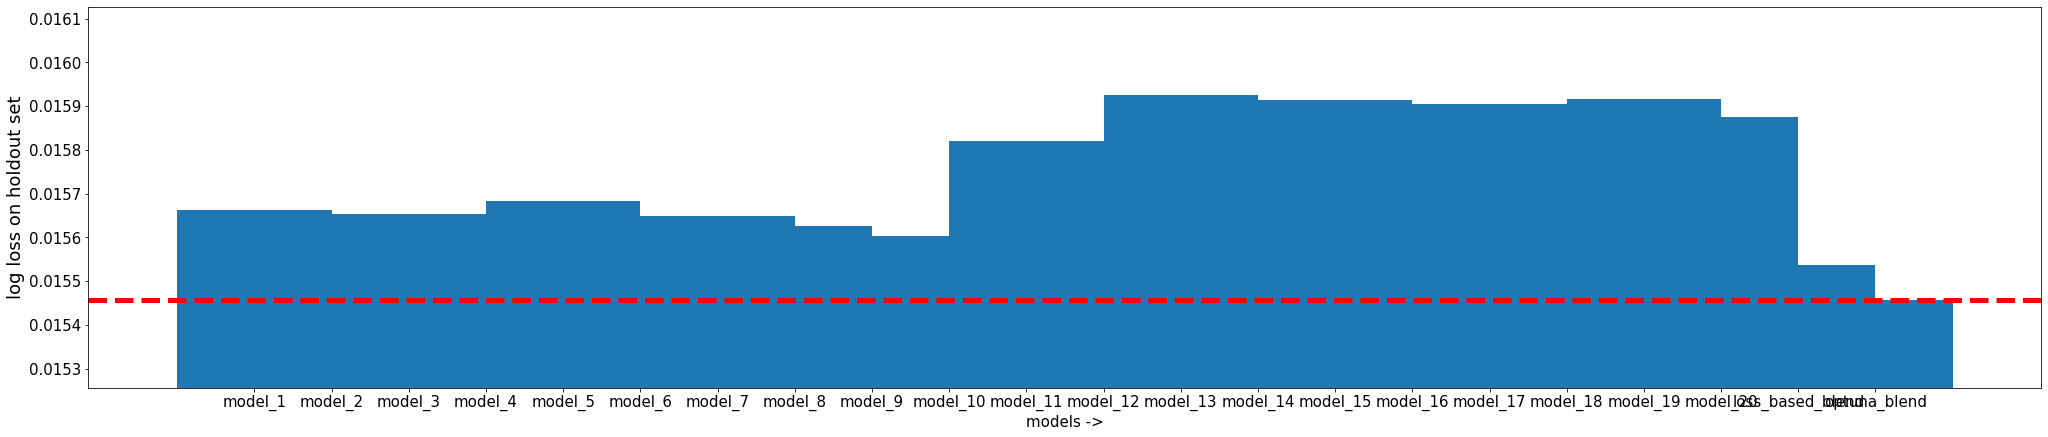

In [216]:

plt.rcParams.update({'font.size': 15})

names = single_log_losses.keys()
vals = single_log_losses.values()

plt.bar(names, vals, width = 0.5)
plt.ylim(min(vals)- .0002, max(vals) + 0.0002)
plt.ylabel("log loss on holdout set", fontsize = 18)
plt.xlabel("models ->", fontsize = 15)
plt.axhline(y = min(vals), linestyle = "--", c = "r", linewidth = 5)
plt.show()